## 2. Comparison of the Performance of 5 Algorithms and Implemented Types of Neighborhoods on All Problem Instances – Plots

### 2.1 Quality
- **Metric**: Distance from the optimum *(specify the exact measure used)*.
- **Scenarios**:
  - Average case
  - Best case
  - *(Optional)* Worst case
- **Note**: Include standard deviations to assess result stability.


Current working directory: /Users/dromaniv/Repositories/putBIAM_QAPsolver/plots


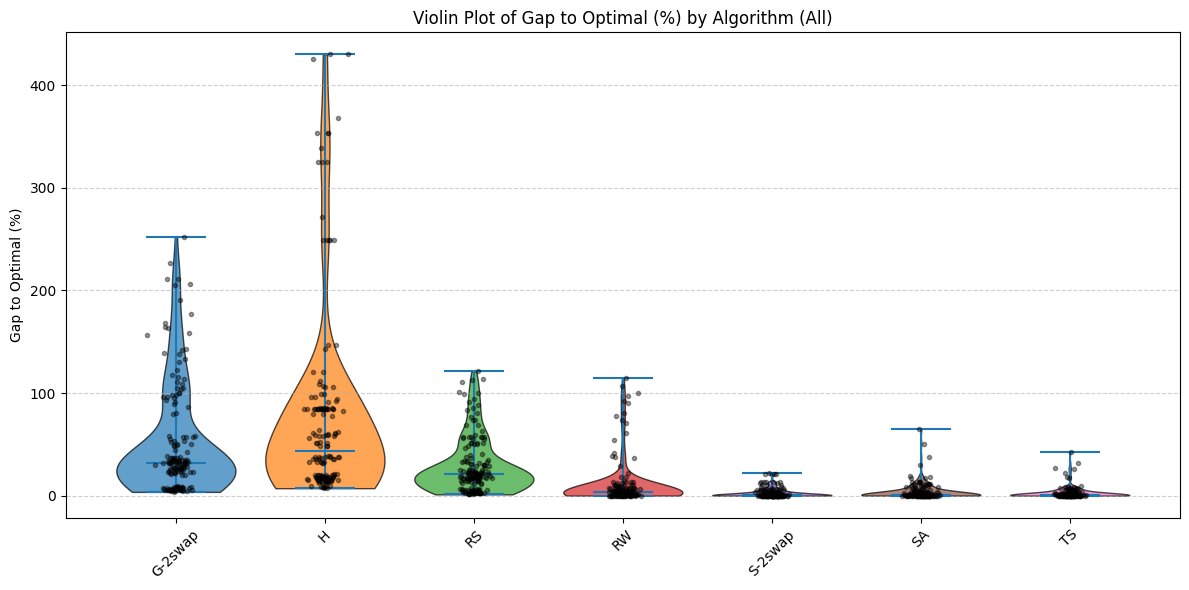

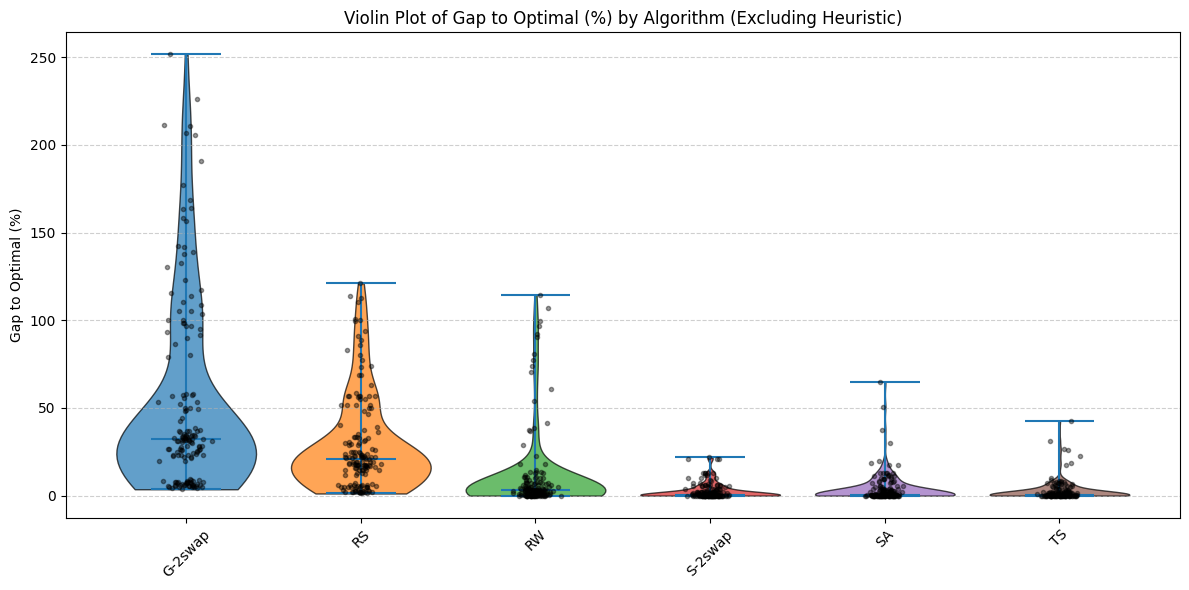

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Make directories for saving plots
os.makedirs("saved", exist_ok=True)

# Load Data
print("Current working directory:", os.getcwd())
experiment_df = pd.read_csv("../experiment_results.csv")
optimal_df = pd.read_csv("../optimal_data.csv")

# Clean instance names
experiment_df["Instance"] = experiment_df["Instance"].str.replace(".dat", "", regex=False).str.lower()
optimal_df["name"] = optimal_df["name"].str.lower()

# Merge data
merged_df = experiment_df.merge(
    optimal_df,
    left_on="Instance",
    right_on="name",
    how="left",
    suffixes=('', '_optimal')
)

# Compute performance metrics
merged_df["GapToOptimal(%)"] = ((merged_df["FinalFitness"] - merged_df["solution"]) / merged_df["solution"]) * 100
merged_df["GapToOptimal_Alt(%)"] = ((merged_df["FinalFitness"] - merged_df["solution"]) / merged_df["FinalFitness"]) * 100
merged_df["%OptimumAchieved"] = (merged_df["solution"] / merged_df["FinalFitness"]) * 100

# Violin Plot A: All Algorithms
def plot_violin_matplotlib(df, title):
    algorithms = sorted(df["Algorithm"].unique())
    data = [df[df["Algorithm"] == algo]["GapToOptimal(%)"] for algo in algorithms]

    fig, ax = plt.subplots(figsize=(12, 6))
    parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True, widths=0.8)

    # Color violins
    colors = plt.cm.tab10.colors
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i % len(colors)])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    # Overlay points
    for i, y in enumerate(data, start=1):
        x = np.random.normal(loc=i, scale=0.05, size=len(y))
        ax.plot(x, y, 'o', color='black', markersize=3, alpha=0.4)

    ax.set_xticks(np.arange(1, len(algorithms) + 1))
    ax.set_xticklabels(algorithms, rotation=45)
    ax.set_ylabel("Gap to Optimal (%)")
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"saved/{title.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

# Plot 1: All Algorithms
plot_violin_matplotlib(merged_df, "Violin Plot of Gap to Optimal (%) by Algorithm (All)")

# Plot 2: Excluding Heuristic (H)
filtered_df = merged_df[merged_df["Algorithm"] != "H"]
plot_violin_matplotlib(filtered_df, "Violin Plot of Gap to Optimal (%) by Algorithm (Excluding Heuristic)")


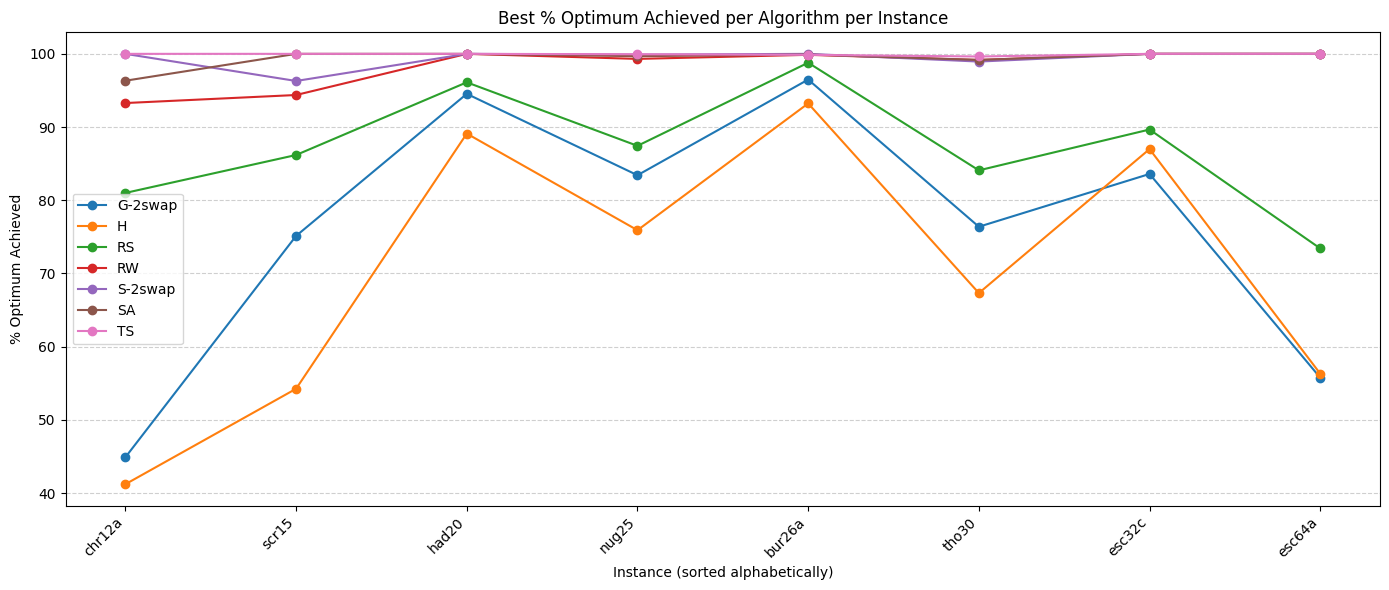

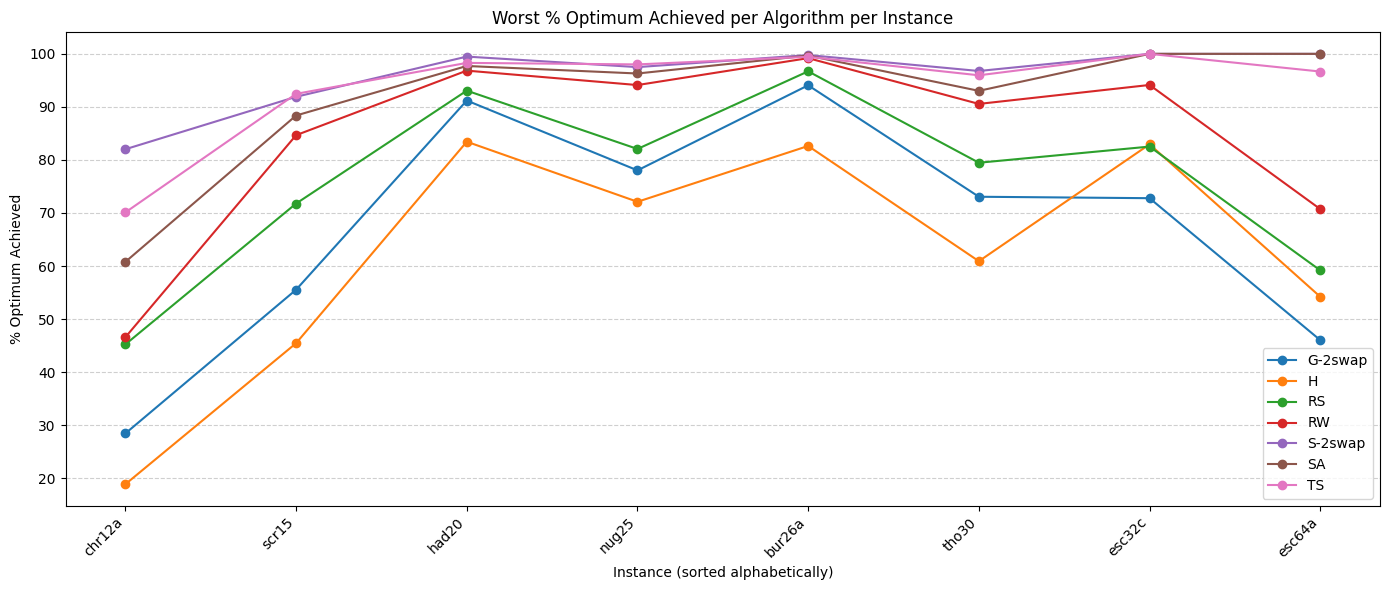

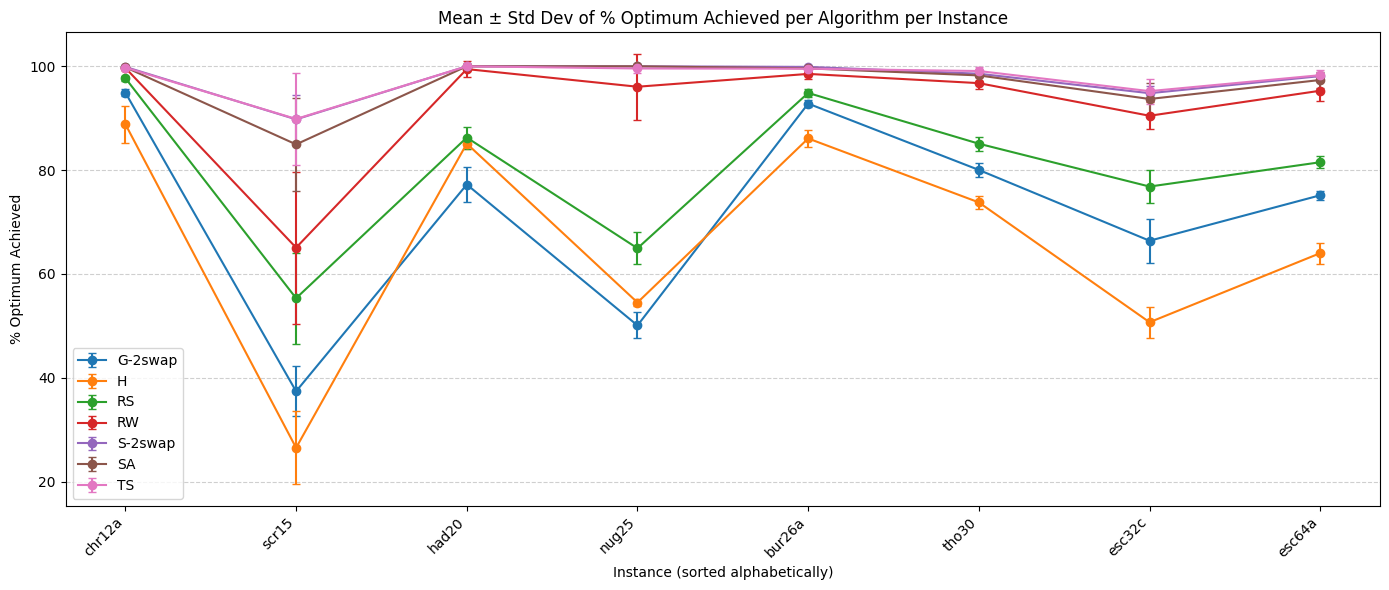

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
merged_df["InstanceSize"] = merged_df["Instance"].str.extract(r'(\d+)').astype(int)
instance_order = (
    merged_df.groupby("Instance")["InstanceSize"]
    .first()
    .sort_values()
    .index
    .tolist()
)

# Colors for consistent styling
algorithm_colors = dict(zip(
    sorted(merged_df["Algorithm"].unique()),
    plt.cm.tab10.colors
))

def plot_quality_by_instance(agg_func, title, with_error=False):
    grouped = merged_df.groupby(["Instance", "Algorithm"])["%OptimumAchieved"]
    if agg_func == "best":
        df_plot = grouped.max().reset_index()
    elif agg_func == "worst":
        df_plot = grouped.min().reset_index()
    elif agg_func == "mean_std":
        df_plot = grouped.agg(['mean', 'std']).reset_index()
    else:
        raise ValueError("Invalid aggregation function")

    fig, ax = plt.subplots(figsize=(14, 6))

    for algo in sorted(merged_df["Algorithm"].unique()):
        if agg_func == "mean_std":
            algo_data = df_plot[df_plot["Algorithm"] == algo].sort_values("Instance")
            mean_values = algo_data["mean"]
            std_values = algo_data["std"]
            ax.errorbar(
                algo_data["Instance"], mean_values, yerr=std_values,
                label=algo, fmt='-o', color=algorithm_colors[algo], capsize=3
            )
        else:
            algo_data = df_plot[df_plot["Algorithm"] == algo]
            algo_data = algo_data.set_index("Instance").reindex(instance_order).reset_index()
            ax.plot(
                algo_data["Instance"], algo_data["%OptimumAchieved"],
                '-o', label=algo, color=algorithm_colors[algo]
            )

    ax.set_title(title)
    ax.set_xlabel("Instance (sorted alphabetically)")
    ax.set_ylabel("% Optimum Achieved")
    ax.set_xticks(range(len(instance_order)))
    ax.set_xticklabels(instance_order, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"saved/{title.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

plot_quality_by_instance("best", "Best % Optimum Achieved per Algorithm per Instance")
plot_quality_by_instance("worst", "Worst % Optimum Achieved per Algorithm per Instance")
plot_quality_by_instance("mean_std", "Mean ± Std Dev of % Optimum Achieved per Algorithm per Instance")


### 2.2 Running Time
- **Metric**: Average execution time
- **Note**: Include standard deviations to assess result stability.

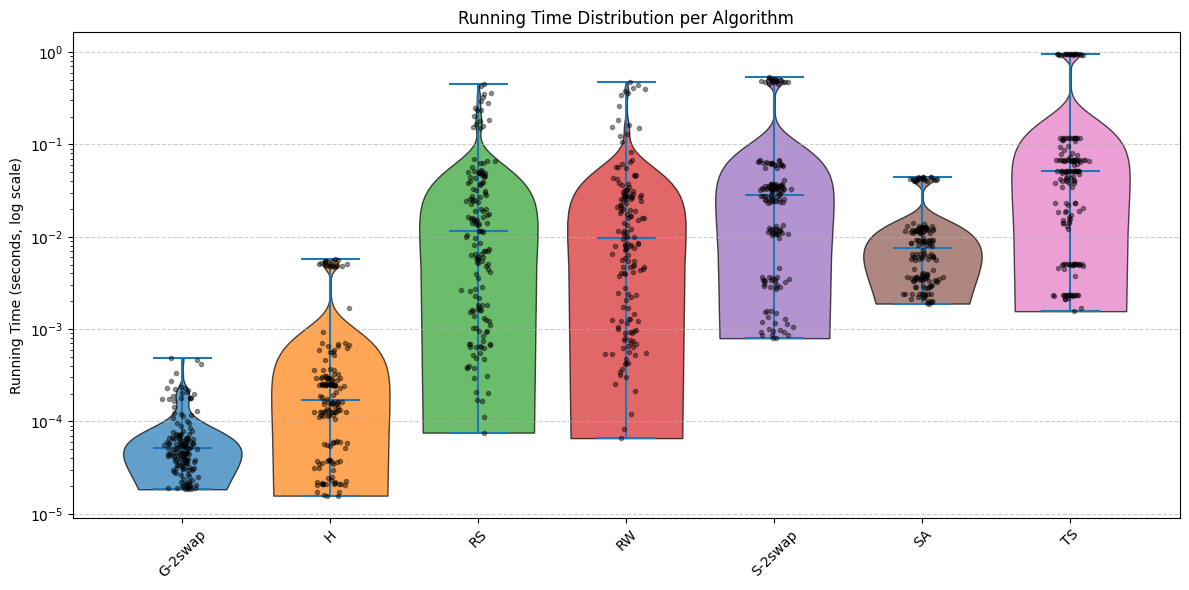

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure TimeSec column exists
merged_df["TimeSec"] = merged_df["TimeMs"] / 1000

# Prepare data
algorithms = merged_df["Algorithm"].unique()
algorithms.sort()
data = [merged_df[merged_df["Algorithm"] == algo]["TimeSec"] for algo in algorithms]

# Create violin plot
fig, ax = plt.subplots(figsize=(12, 6))
parts = ax.violinplot(
    data,
    showmeans=False,
    showmedians=True,
    showextrema=True,
    widths=0.8
)

# Optional: Color each violin differently
colors = plt.cm.tab10.colors
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i % len(colors)])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add individual data points
for i, algo_data in enumerate(data, start=1):
    y = algo_data
    x = np.random.normal(loc=i, scale=0.05, size=len(y))  # jitter for visibility
    ax.plot(x, y, 'o', color='black', markersize=3, alpha=0.4)

# Formatting
ax.set_xticks(np.arange(1, len(algorithms) + 1))
ax.set_xticklabels(algorithms, rotation=45)
ax.set_ylabel("Running Time (seconds, log scale)")
ax.set_yscale("log")
ax.set_title("Running Time Distribution per Algorithm")
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("saved/running_time_distribution_per_algorithm.svg", format="svg")
plt.show()


In [72]:
# Sort instance order alphabetically or by size
instance_order = (
    merged_df.groupby("Instance")["InstanceSize"]
    .first()
    .sort_values()
    .index
    .tolist()
)
# Create color map for algorithms
algorithm_colors = dict(zip(
    sorted(merged_df["Algorithm"].unique()),
    plt.cm.tab10.colors
))

def plot_runtime_by_instance(agg_func, title):
    grouped = merged_df.groupby(["Instance", "Algorithm"])["TimeSec"]
    if agg_func == "best":
        df_plot = grouped.min().reset_index()
    elif agg_func == "worst":
        df_plot = grouped.max().reset_index()
    elif agg_func == "mean_std":
        df_plot = grouped.agg(['mean', 'std']).reset_index()
    else:
        raise ValueError("Invalid aggregation function")

    fig, ax = plt.subplots(figsize=(14, 6))

    for algo in sorted(merged_df["Algorithm"].unique()):
        if agg_func == "mean_std":
            algo_data = df_plot[df_plot["Algorithm"] == algo].sort_values("Instance")
            mean_vals = algo_data["mean"]
            std_vals = algo_data["std"]
            ax.errorbar(
                algo_data["Instance"], mean_vals, yerr=std_vals,
                label=algo, fmt='-o', color=algorithm_colors[algo], capsize=3
            )
        else:
            algo_data = df_plot[df_plot["Algorithm"] == algo]
            algo_data = algo_data.set_index("Instance").reindex(instance_order).reset_index()
            ax.plot(
                algo_data["Instance"], algo_data["TimeSec"],
                '-o', label=algo, color=algorithm_colors[algo]
            )

    ax.set_title(title)
    ax.set_xlabel("Instance (sorted alphabetically)")
    ax.set_ylabel("Running Time (seconds, log scale)")
    ax.set_yscale("log")
    ax.set_xticks(range(len(instance_order)))
    ax.set_xticklabels(instance_order, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"saved/{title.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

plot_runtime_by_instance("best", "Best Case Running Time per Algorithm per Instance")
plot_runtime_by_instance("worst", "Worst Case Running Time per Algorithm per Instance")
plot_runtime_by_instance("mean_std", "Mean ± Std Dev of Running Time per Algorithm per Instance")

### 2.3 Efficiency of Algorithms
- **Metric**: Quality over time
- **Suggested Measure**: *(Propose and justify the chosen measure, e.g., inverse of normalized cost per time unit, or solution improvement per time unit)*
- **Note**: Include standard deviations to assess result stability.

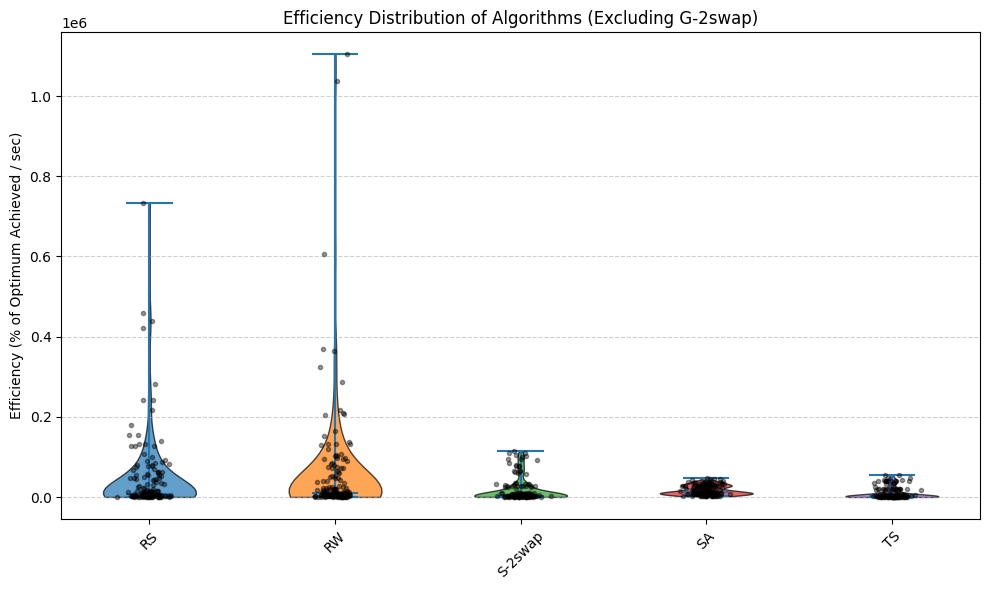

In [73]:
import matplotlib.pyplot as plt
import numpy as np

merged_df["Efficiency"] = merged_df["%OptimumAchieved"] / merged_df["TimeSec"]

def plot_efficiency_violin(dataframe, exclude_algos=None, title_suffix=""):
    # Optionally filter out excluded algorithms
    if exclude_algos:
        dataframe = dataframe[~dataframe["Algorithm"].isin(exclude_algos)]

    # Prepare data
    algorithms = sorted(dataframe["Algorithm"].unique())
    efficiency_data = [dataframe[dataframe["Algorithm"] == algo]["Efficiency"] for algo in algorithms]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    parts = ax.violinplot(efficiency_data, showmeans=False, showmedians=True, showextrema=True)

    # Color violins
    colors = plt.cm.tab10.colors
    for i, body in enumerate(parts['bodies']):
        body.set_facecolor(colors[i % len(colors)])
        body.set_edgecolor('black')
        body.set_alpha(0.7)

    # Overlay individual points
    for i, eff_values in enumerate(efficiency_data, start=1):
        x = np.random.normal(i, 0.05, size=len(eff_values))
        ax.plot(x, eff_values, 'o', color='black', markersize=3, alpha=0.4)

    # Customize
    ax.set_xticks(np.arange(1, len(algorithms) + 1))
    ax.set_xticklabels(algorithms, rotation=45)
    ax.set_ylabel("Efficiency (% of Optimum Achieved / sec)")
    ax.set_title(f"Efficiency Distribution of Algorithms {title_suffix}")
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"saved/efficiency_distribution{title_suffix.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

plot_efficiency_violin(merged_df, title_suffix="(All Algorithms)")

plot_efficiency_violin(merged_df, exclude_algos=["G-2swap", "H"], title_suffix="(Excluding G-2swap)")


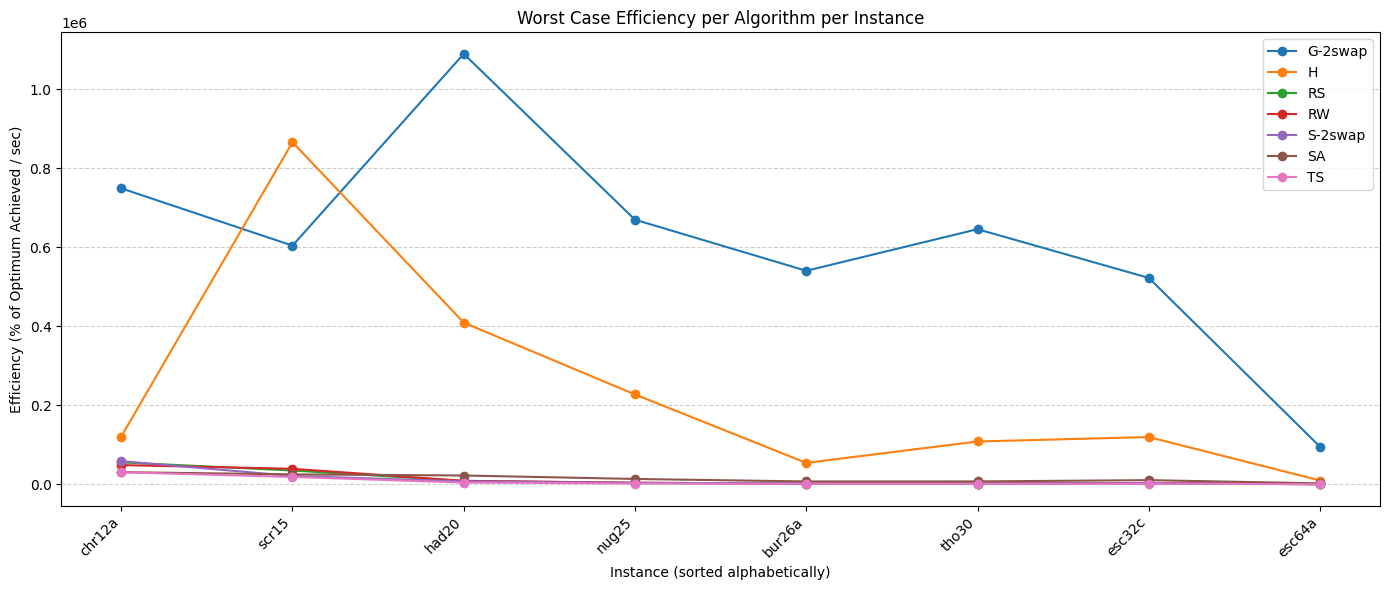

In [74]:

# Calculate efficiency again (in case it was reset)
merged_df["Efficiency"] = merged_df["%OptimumAchieved"] / merged_df["TimeSec"]

instance_order = (
    merged_df.groupby("Instance")["InstanceSize"]
    .first()
    .sort_values()
    .index
    .tolist()
)
# Algorithm color mapping
algorithm_colors = dict(zip(
    sorted(merged_df["Algorithm"].unique()),
    plt.cm.tab10.colors
))

def plot_efficiency_by_instance(agg_func, title):
    grouped = merged_df.groupby(["Instance", "Algorithm"])["Efficiency"]
    if agg_func == "best":
        df_plot = grouped.max().reset_index()
    elif agg_func == "worst":
        df_plot = grouped.min().reset_index()
    elif agg_func == "mean_std":
        df_plot = grouped.agg(['mean', 'std']).reset_index()
    else:
        raise ValueError("Invalid aggregation function")

    fig, ax = plt.subplots(figsize=(14, 6))

    for algo in sorted(merged_df["Algorithm"].unique()):
        if agg_func == "mean_std":
            algo_data = df_plot[df_plot["Algorithm"] == algo].sort_values("Instance")
            mean_vals = algo_data["mean"]
            std_vals = algo_data["std"]
            ax.errorbar(
                algo_data["Instance"], mean_vals, yerr=std_vals,
                label=algo, fmt='-o', color=algorithm_colors[algo], capsize=3
            )
        else:
            algo_data = df_plot[df_plot["Algorithm"] == algo]
            algo_data = algo_data.set_index("Instance").reindex(instance_order).reset_index()
            ax.plot(
                algo_data["Instance"], algo_data["Efficiency"],
                '-o', label=algo, color=algorithm_colors[algo]
            )

    ax.set_title(title)
    ax.set_xlabel("Instance (sorted alphabetically)")  # 🔁 Sort by size if desired
    ax.set_ylabel("Efficiency (% of Optimum Achieved / sec)")
    ax.set_xticks(range(len(instance_order)))
    ax.set_xticklabels(instance_order, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"saved/{title.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

# ⏱️ Plot best, worst, and mean ± std efficiency
plot_efficiency_by_instance("best", "Best Case Efficiency per Algorithm per Instance")
plot_efficiency_by_instance("worst", "Worst Case Efficiency per Algorithm per Instance")
plot_efficiency_by_instance("mean_std", "Mean ± Std Dev of Efficiency per Algorithm per Instance")


### 2.4 Number of Algorithm Steps (G, S)
- **Definition**: Step = changing the current solution
- **Metric**: Average number of steps
- **Note**: Include standard deviations to assess result stability.

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only G and S
gs_df = merged_df[merged_df["Algorithm"].isin(["G-2swap", "S-2swap"])]

# Prepare data
algos = ["G-2swap", "S-2swap"]
steps_data = [gs_df[gs_df["Algorithm"] == algo]["Steps"] for algo in algos]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(steps_data, showmeans=False, showmedians=True, showextrema=True)

# Color violins
colors = ["#5DADE2", "#58D68D"]
for i, body in enumerate(parts["bodies"]):
    body.set_facecolor(colors[i % len(colors)])
    body.set_edgecolor("black")
    body.set_alpha(0.7)

# Overlay data points
for i, step_vals in enumerate(steps_data, start=1):
    x = np.random.normal(i, 0.05, size=len(step_vals))
    ax.plot(x, step_vals, 'o', color='black', alpha=0.4, markersize=3)

# Customize
ax.set_xticks(np.arange(1, len(algos) + 1))
ax.set_xticklabels(algos)
ax.set_ylabel("Steps")
ax.set_xlabel("Algorithm")
ax.set_title("Distribution of Number of Steps (G-2swap and S-2swap)")
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("saved/steps_distribution_g_s.svg", format="svg")
plt.show()


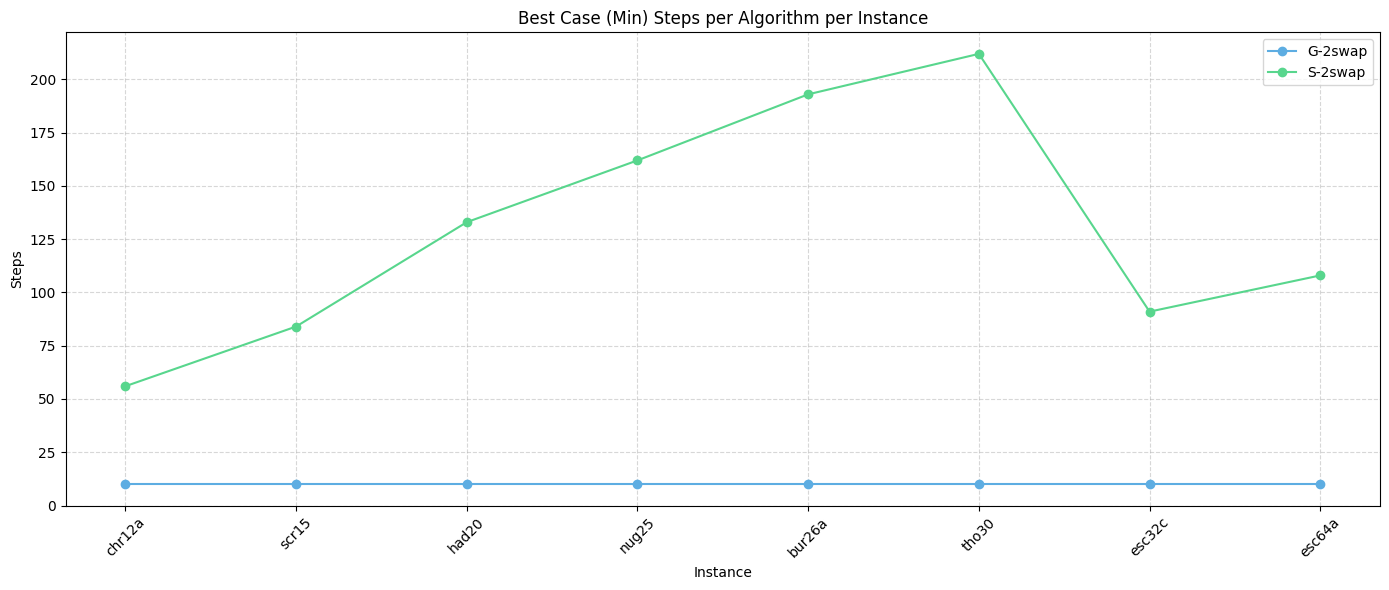

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Filter G and S only
gs_df = merged_df[merged_df["Algorithm"].isin(["G-2swap", "S-2swap"])]

instances_sorted = (
    merged_df.groupby("Instance")["InstanceSize"]
    .first()
    .sort_values()
    .index
    .tolist()
)
# instances_sorted = sorted(gs_df["Instance"].unique())

# Optionally: sort by instance size
# instances_sorted = sorted(instances, key=lambda x: int(x.split("-")[1]))

# Prepare statistics
grouped = gs_df.groupby(["Instance", "Algorithm"])["Steps"].agg(["min", "max", "mean", "std"]).reset_index()

# Setup plot styles
algorithms = ["G-2swap", "S-2swap"]
colors = {"G-2swap": "#5DADE2", "S-2swap": "#58D68D"}
x = np.arange(len(instances_sorted))

def plot_line_stat(stat_name, ylabel, title, yvals_key):
    plt.figure(figsize=(14, 6))
    for algo in algorithms:
        algo_data = grouped[grouped["Algorithm"] == algo].set_index("Instance").reindex(instances_sorted)
        yvals = algo_data[yvals_key]
        plt.plot(x, yvals, label=algo, marker='o', color=colors[algo])
    plt.xticks(x, instances_sorted, rotation=45)
    plt.ylabel(ylabel)
    plt.xlabel("Instance")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"saved/{title.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

# Plot 1: Best case (min)
plot_line_stat("Min", "Steps", "Best Case (Min) Steps per Algorithm per Instance", "min")

# Plot 2: Worst case (max)
plot_line_stat("Max", "Steps", "Worst Case (Max) Steps per Algorithm per Instance", "max")

# Plot 3: Mean ± std
plt.figure(figsize=(14, 6))
for algo in algorithms:
    algo_data = grouped[grouped["Algorithm"] == algo].set_index("Instance").reindex(instances_sorted)
    means = algo_data["mean"]
    stds = algo_data["std"]
    plt.errorbar(x, means, yerr=stds, label=algo, fmt='-o', capsize=4, color=colors[algo])
plt.xticks(x, instances_sorted, rotation=45)
plt.ylabel("Steps")
plt.xlabel("Instance")
plt.title("Average Steps per Algorithm per Instance (with Std Dev)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("saved/mean_std_steps_per_algorithm_per_instance.svg", format="svg")
plt.show()


### 2.5 Number of Evaluated Solutions (G, S, RS, RW)
- **Definition**: Evaluated = visited and at least partially evaluated
- **Metric**: Average number of evaluated solutions
- **Note**: Include standard deviations to assess result stability.

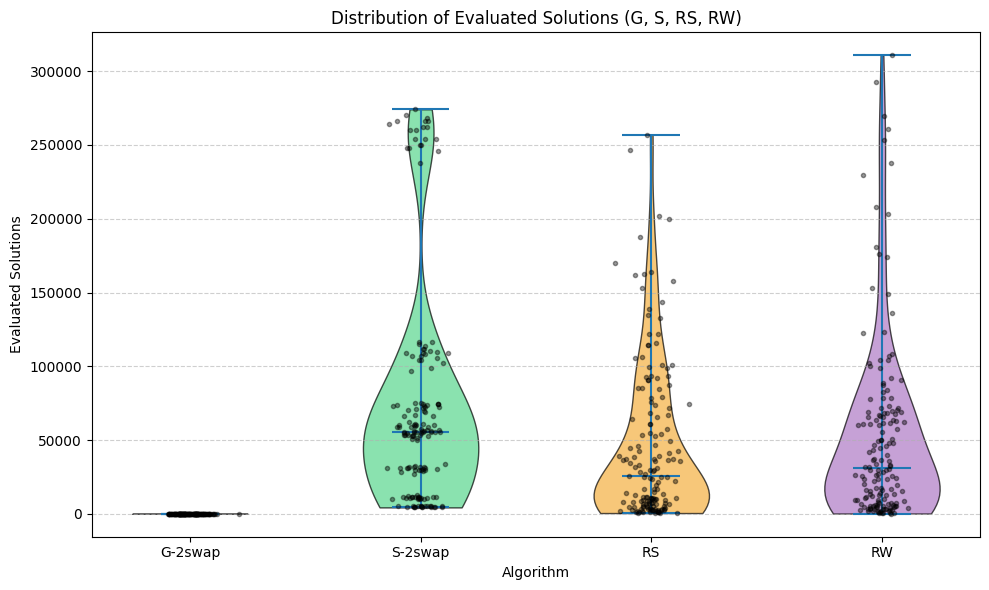

In [77]:
# Filter selected algorithms
eval_df = merged_df[merged_df["Algorithm"].isin(["G-2swap", "S-2swap", "RS", "RW"])]

# Prepare data
algos = ["G-2swap", "S-2swap", "RS", "RW"]
eval_data = [eval_df[eval_df["Algorithm"] == algo]["Evaluations"] for algo in algos]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
parts = ax.violinplot(eval_data, showmeans=False, showmedians=True, showextrema=True)

# Color violins
colors = ["#5DADE2", "#58D68D", "#F5B041", "#AF7AC5"]
for i, body in enumerate(parts["bodies"]):
    body.set_facecolor(colors[i % len(colors)])
    body.set_edgecolor("black")
    body.set_alpha(0.7)

# Overlay data points
for i, eval_vals in enumerate(eval_data, start=1):
    x = np.random.normal(i, 0.05, size=len(eval_vals))
    ax.plot(x, eval_vals, 'o', color='black', alpha=0.4, markersize=3)

# Customize
ax.set_xticks(np.arange(1, len(algos) + 1))
ax.set_xticklabels(algos)
ax.set_ylabel("Evaluated Solutions")
ax.set_xlabel("Algorithm")
ax.set_title("Distribution of Evaluated Solutions (G, S, RS, RW)")
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("saved/evaluated_solutions_distribution_g_s_rs_rw.svg", format="svg")
plt.show()


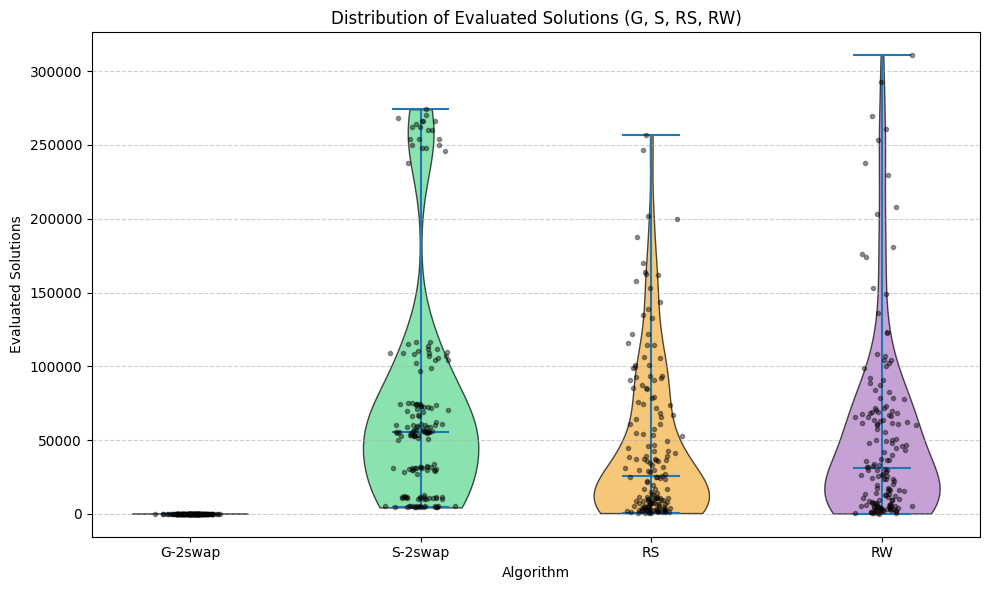

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Filter selected algorithms
eval_df = merged_df[merged_df["Algorithm"].isin(["G-2swap", "S-2swap", "RS", "RW"])]

# Prepare data
algos = ["G-2swap", "S-2swap", "RS", "RW"]
eval_data = [eval_df[eval_df["Algorithm"] == algo]["Evaluations"] for algo in algos]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
parts = ax.violinplot(eval_data, showmeans=False, showmedians=True, showextrema=True)

# Color violins
colors = ["#5DADE2", "#58D68D", "#F5B041", "#AF7AC5"]
for i, body in enumerate(parts["bodies"]):
    body.set_facecolor(colors[i % len(colors)])
    body.set_edgecolor("black")
    body.set_alpha(0.7)

# Overlay data points
for i, eval_vals in enumerate(eval_data, start=1):
    x = np.random.normal(i, 0.05, size=len(eval_vals))  # Jitter for separation
    ax.plot(x, eval_vals, 'o', color='black', alpha=0.4, markersize=3)

# Customize appearance
ax.set_xticks(np.arange(1, len(algos) + 1))
ax.set_xticklabels(algos)
ax.set_ylabel("Evaluated Solutions")
ax.set_xlabel("Algorithm")
ax.set_title("Distribution of Evaluated Solutions (G, S, RS, RW)")
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("saved/evaluated_solutions_distribution_g_s_rs_rw.svg", format="svg")
plt.show()


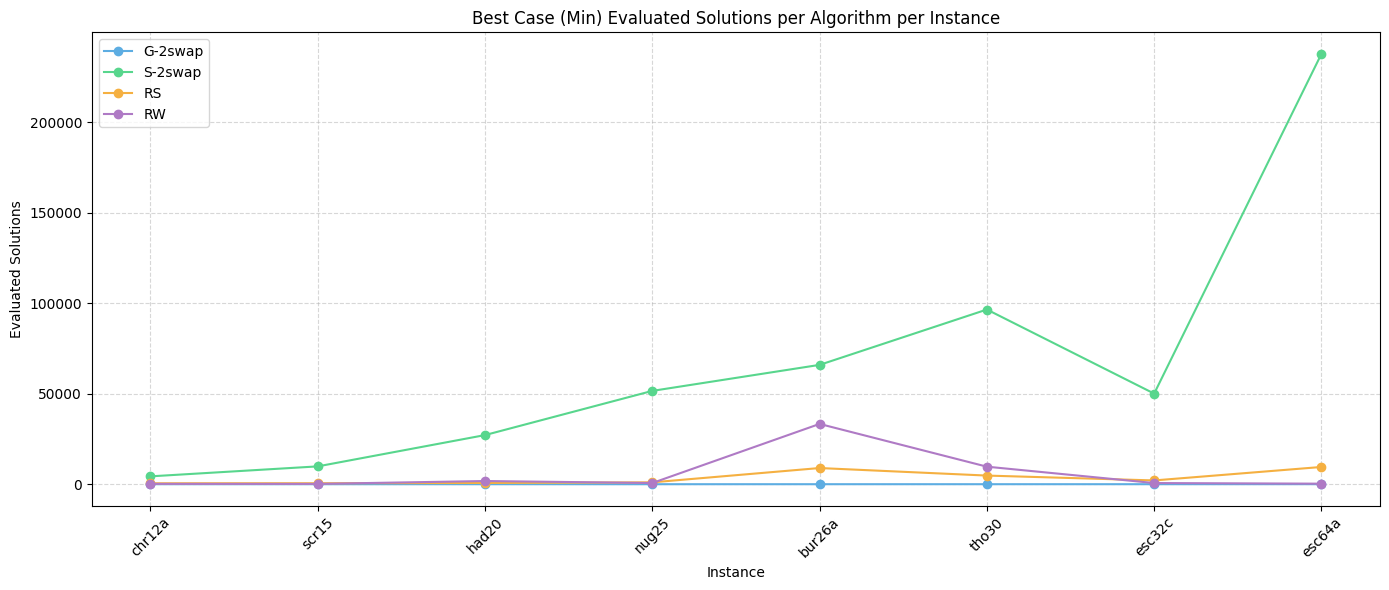

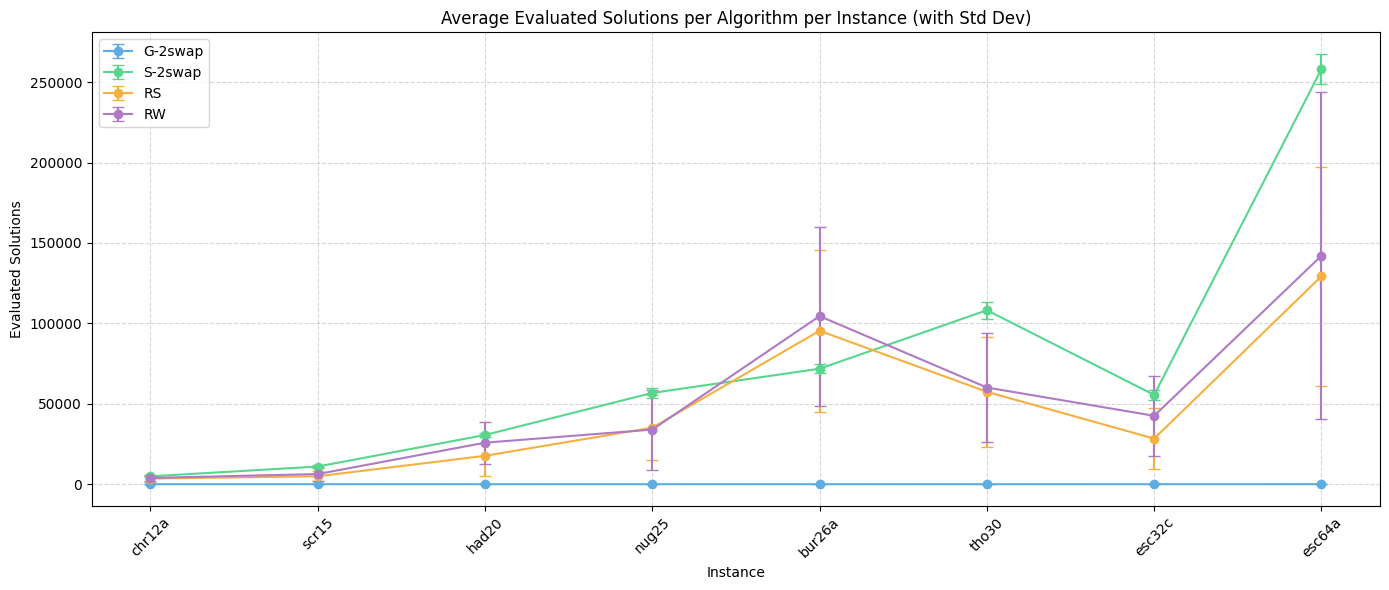

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Filter selected algorithms
eval_df = merged_df[merged_df["Algorithm"].isin(["G-2swap", "S-2swap", "RS", "RW"])].copy()

eval_df["InstanceSize"] = eval_df["Instance"].str.extract(r'(\d+)').astype(int)
instances_sorted = (
    eval_df.groupby("Instance")["InstanceSize"]
    .first()
    .sort_values()
    .index
    .tolist()
)

# Group by instance + algorithm to compute stats
grouped = eval_df.groupby(["Instance", "Algorithm"])["Evaluations"].agg(["min", "max", "mean", "std"]).reset_index()

# Line plot helper
def plot_line_eval_stat(stat_name, ylabel, title, yvals_key):
    x = np.arange(len(instances_sorted))
    colors = {
        "G-2swap": "#5DADE2",
        "S-2swap": "#58D68D",
        "RS": "#F5B041",
        "RW": "#AF7AC5"
    }

    plt.figure(figsize=(14, 6))
    for algo in ["G-2swap", "S-2swap", "RS", "RW"]:
        algo_data = grouped[grouped["Algorithm"] == algo].set_index("Instance").reindex(instances_sorted)
        yvals = algo_data[yvals_key]
        plt.plot(x, yvals, label=algo, marker='o', color=colors[algo])

    plt.xticks(x, instances_sorted, rotation=45)
    plt.ylabel(ylabel)
    plt.xlabel("Instance")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"saved/{title.replace(' ', '_').lower()}.svg", format="svg")
    plt.show()

# Plot 1: Min
plot_line_eval_stat("Min", "Evaluated Solutions", "Best Case (Min) Evaluated Solutions per Algorithm per Instance", "min")

# Plot 2: Max
plot_line_eval_stat("Max", "Evaluated Solutions", "Worst Case (Max) Evaluated Solutions per Algorithm per Instance", "max")

# Plot 3: Mean ± std
x = np.arange(len(instances_sorted))
plt.figure(figsize=(14, 6))
colors = {
    "G-2swap": "#5DADE2",
    "S-2swap": "#58D68D",
    "RS": "#F5B041",
    "RW": "#AF7AC5"
}
for algo in ["G-2swap", "S-2swap", "RS", "RW"]:
    algo_data = grouped[grouped["Algorithm"] == algo].set_index("Instance").reindex(instances_sorted)
    means = algo_data["mean"]
    stds = algo_data["std"]
    plt.errorbar(x, means, yerr=stds, fmt='-o', capsize=4, label=algo, color=colors[algo])

plt.xticks(x, instances_sorted, rotation=45)
plt.ylabel("Evaluated Solutions")
plt.xlabel("Instance")
plt.title("Average Evaluated Solutions per Algorithm per Instance (with Std Dev)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("saved/mean_std_evaluated_solutions_per_algorithm_per_instance.svg", format="svg")
plt.show()


## 3. G, S – Initial vs. Final Solution Quality

- **Plot**: Scatter plot of the quality of the initial solution (x-axis) vs. the quality of the final solution (y-axis)
- **Repetitions**: At least 200 (use small points)
- **Instances**: Select several interesting instances that show heterogeneity
- **Interpretation**:
  - Provide and interpret the correlation (e.g., Pearson’s r)
  - Discuss whether poor initial solutions still lead to good final solutions or not


Global Pearson Correlations (all instances):
  G-2swap: 0.9735
  S-2swap: 0.6051
  SA: 0.6194
  TS: 0.6315


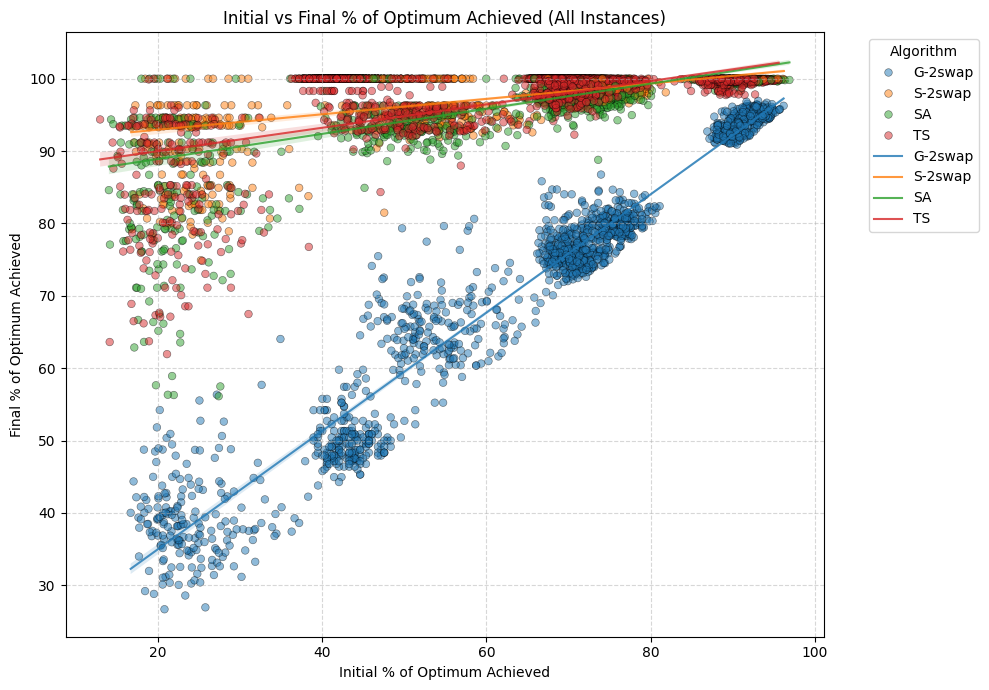


Pearson Correlations per Instance:

Instance: bur26a
  G-2swap: 0.2385
  S-2swap: 0.0689
  SA: -0.0081
  TS: -0.0269


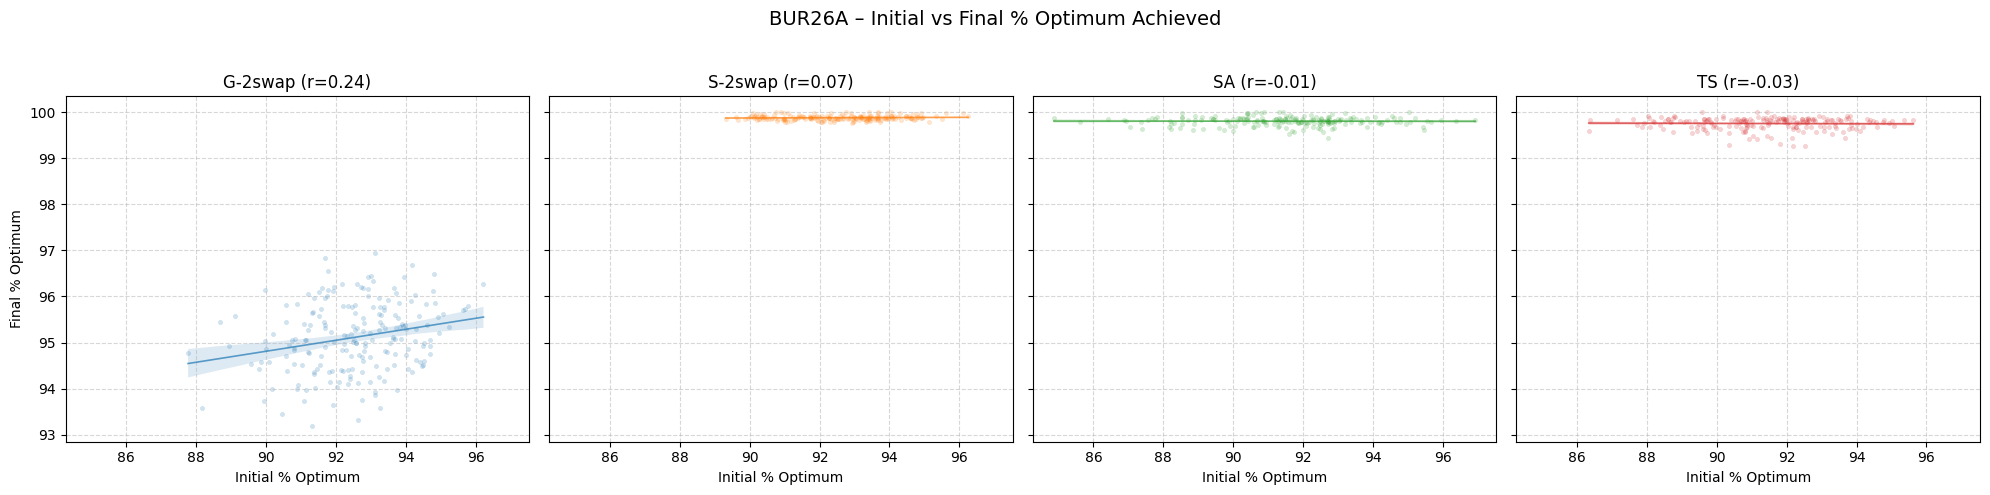


Instance: chr12a
  G-2swap: 0.0928
  S-2swap: 0.0130
  SA: 0.0374
  TS: -0.0225


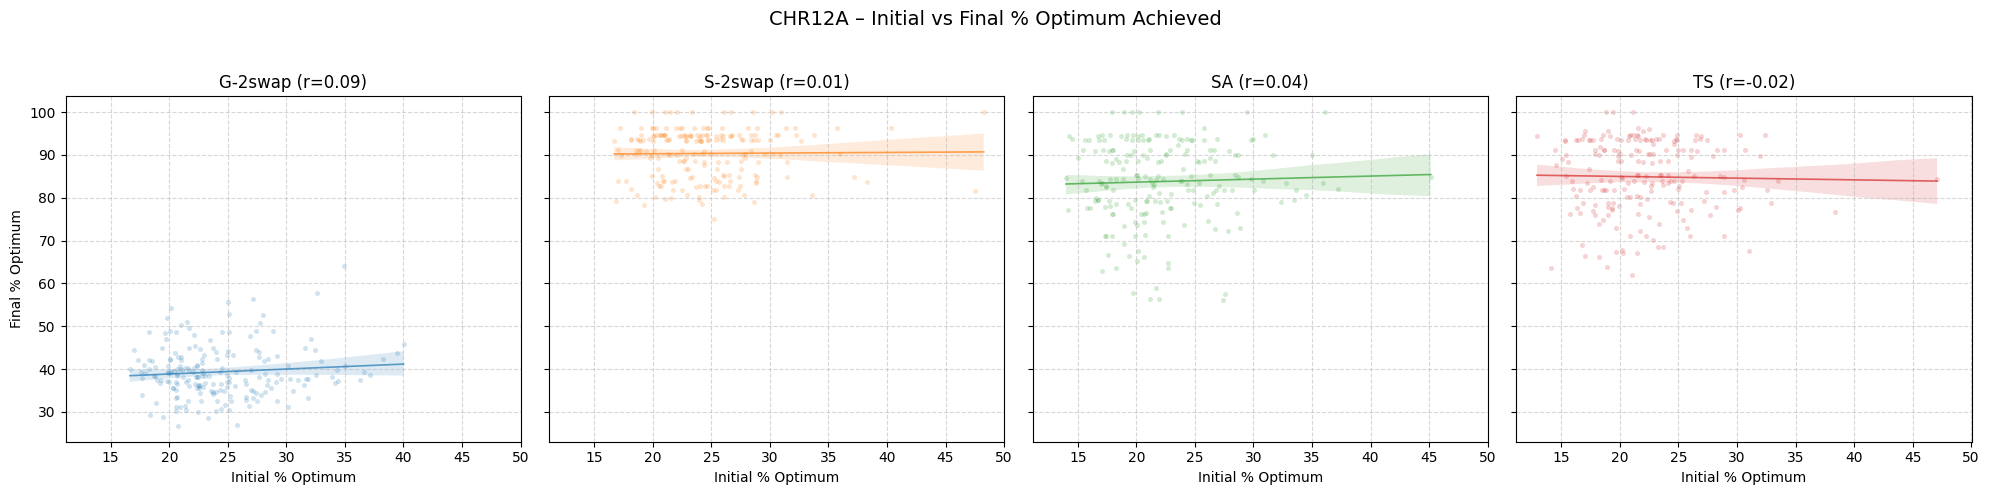


Instance: esc32c
  G-2swap: 0.1189
  S-2swap: nan
  SA: nan
  TS: 0.0888


/var/folders/br/srt5dpqx6pn3pb4j7tj6d1vh0000gp/T/ipykernel_70263/3346841882.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(algo_df["%OptimumAchieved_Initial"], algo_df["%OptimumAchieved_Final"])
/var/folders/br/srt5dpqx6pn3pb4j7tj6d1vh0000gp/T/ipykernel_70263/3346841882.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(algo_df["%OptimumAchieved_Initial"], algo_df["%OptimumAchieved_Final"])


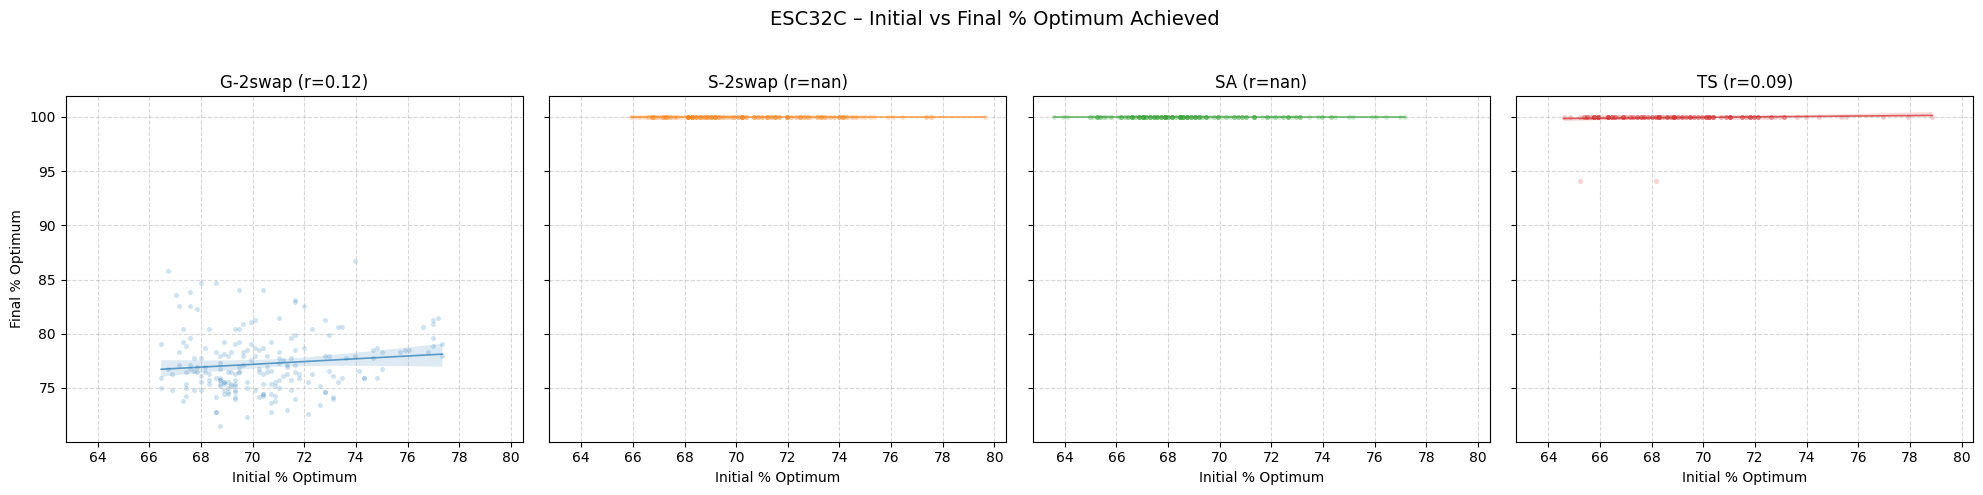


Instance: esc64a
  G-2swap: 0.2714
  S-2swap: nan
  SA: 0.0452
  TS: -0.0444


/var/folders/br/srt5dpqx6pn3pb4j7tj6d1vh0000gp/T/ipykernel_70263/3346841882.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(algo_df["%OptimumAchieved_Initial"], algo_df["%OptimumAchieved_Final"])



Instance: had20
  G-2swap: 0.1234
  S-2swap: 0.0353
  SA: -0.0026
  TS: 0.0209


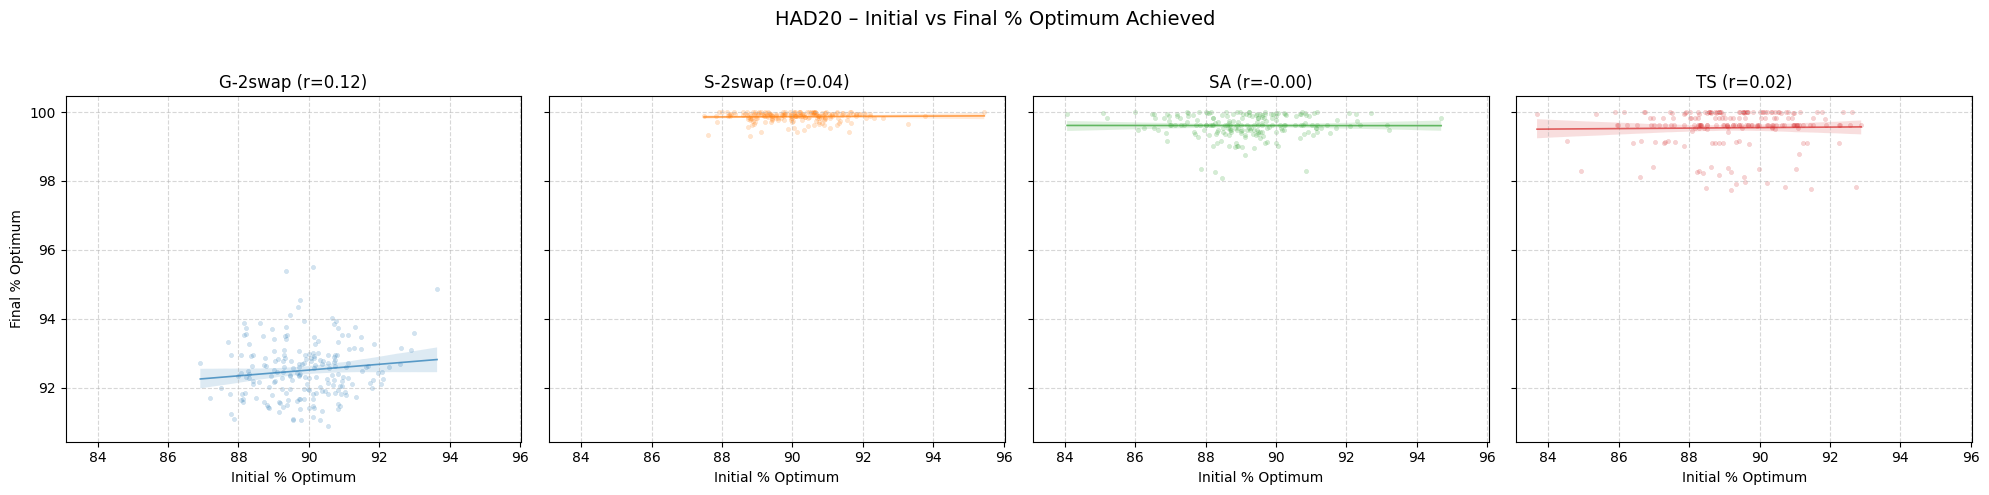


Instance: nug25
  G-2swap: 0.2247
  S-2swap: -0.0379
  SA: 0.0197
  TS: 0.1031


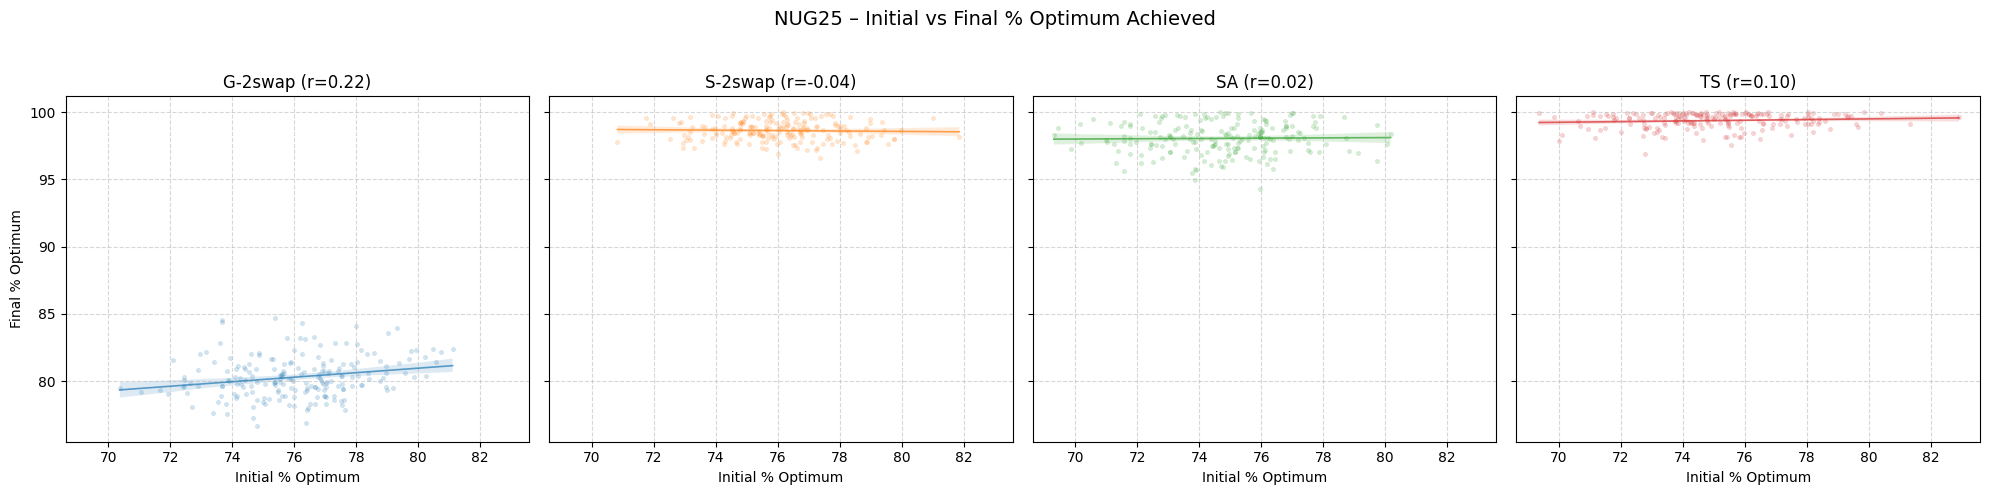


Instance: scr15
  G-2swap: 0.1675
  S-2swap: 0.0258
  SA: -0.0779
  TS: -0.0821


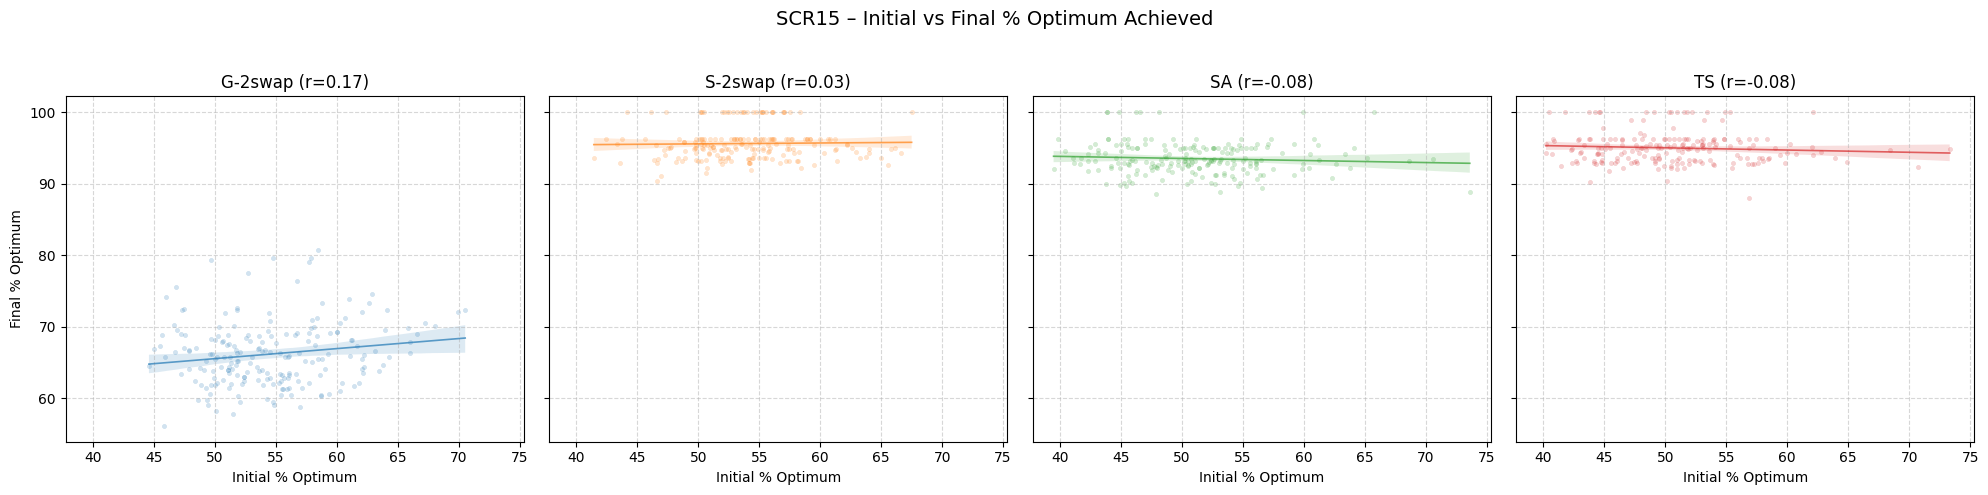


Instance: tho30
  G-2swap: 0.2280
  S-2swap: 0.1766
  SA: 0.0113
  TS: 0.0470


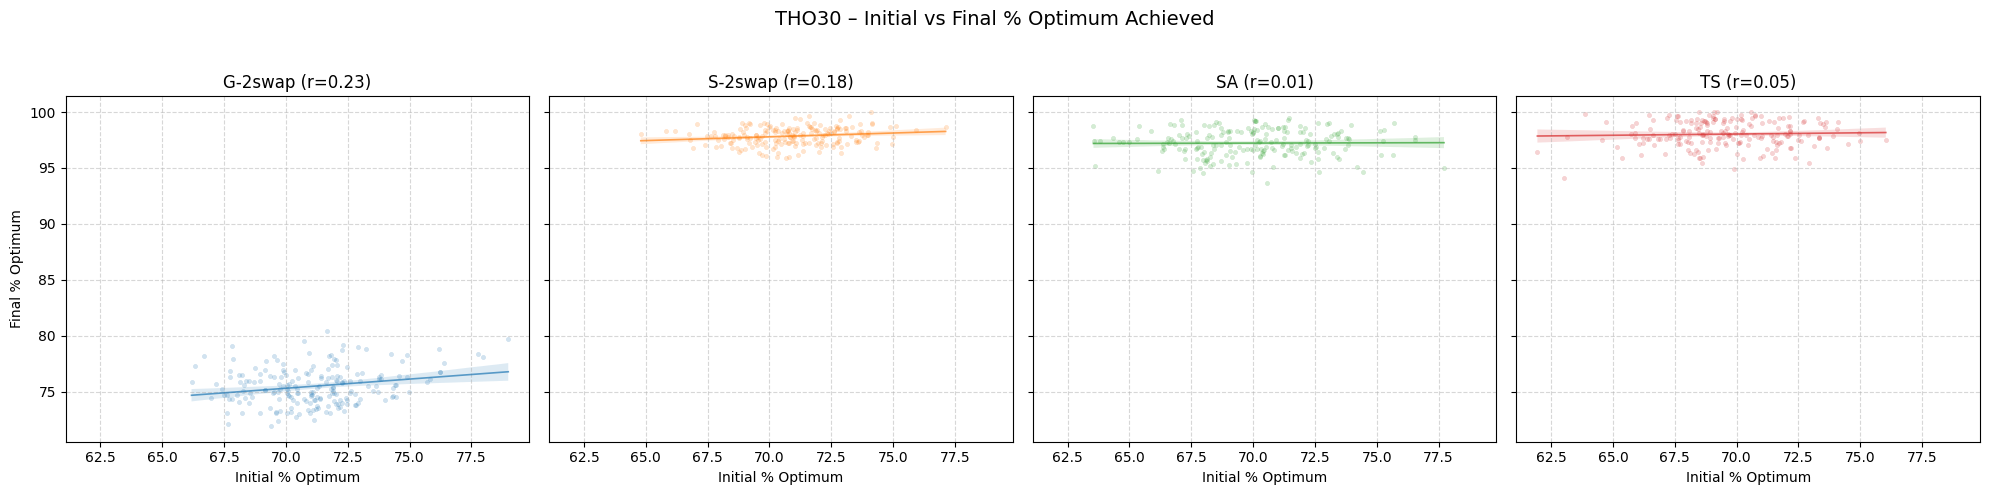

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load data
experiment_ls_df = pd.read_csv("../experiment_results_ls.csv")
optimal_df = pd.read_csv("../optimal_data.csv")

# Normalize instance names
experiment_ls_df["Instance"] = experiment_ls_df["Instance"].str.replace(".dat", "", regex=False).str.lower()
optimal_df["name"] = optimal_df["name"].str.lower()

# Merge
merged_df = experiment_ls_df.merge(
    optimal_df,
    left_on="Instance",
    right_on="name",
    how="left"
)

# Compute metrics
merged_df["%OptimumAchieved_Initial"] = (merged_df["solution"] / merged_df["InitialFitness"]) * 100
merged_df["%OptimumAchieved_Final"] = (merged_df["solution"] / merged_df["FinalFitness"]) * 100

# Global Pearson correlations
print("Global Pearson Correlations (all instances):")
algorithms = merged_df["Algorithm"].unique()
colors = sns.color_palette("tab10", len(algorithms))

for algo in algorithms:
    algo_df = merged_df[merged_df["Algorithm"] == algo]
    corr, _ = pearsonr(algo_df["%OptimumAchieved_Initial"], algo_df["%OptimumAchieved_Final"])
    print(f"  {algo}: {corr:.4f}")

# Global scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=merged_df,
    x="%OptimumAchieved_Initial",
    y="%OptimumAchieved_Final",
    hue="Algorithm",
    alpha=0.5,
    s=30,
    edgecolor='black'
)

for algo, color in zip(algorithms, colors):
    algo_df = merged_df[merged_df["Algorithm"] == algo]
    sns.regplot(
        data=algo_df,
        x="%OptimumAchieved_Initial",
        y="%OptimumAchieved_Final",
        scatter=False,
        label=algo,
        color=color,
        line_kws={"linewidth": 1.5, "alpha": 0.8}
    )

plt.title("Initial vs Final % of Optimum Achieved (All Instances)")
plt.xlabel("Initial % of Optimum Achieved")
plt.ylabel("Final % of Optimum Achieved")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("saved/global_scatter_initial_vs_final.svg", format="svg")
plt.show()

# Per-instance Pearson and subplots
instances = sorted(merged_df["Instance"].unique())
print("\nPearson Correlations per Instance:")

for instance in instances:
    inst_df = merged_df[merged_df["Instance"] == instance]
    print(f"\nInstance: {instance}")
    
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(algorithms),
        figsize=(5 * len(algorithms), 5),
        sharex=True,
        sharey=True
    )

    if len(algorithms) == 1:
        axes = [axes] 

    for ax, algo, color in zip(axes, algorithms, colors):
        algo_df = inst_df[inst_df["Algorithm"] == algo]
        if algo_df.empty:
            ax.axis('off')
            continue

        corr, _ = pearsonr(algo_df["%OptimumAchieved_Initial"], algo_df["%OptimumAchieved_Final"])
        print(f"  {algo}: {corr:.4f}")

        sns.scatterplot(
            data=algo_df,
            x="%OptimumAchieved_Initial",
            y="%OptimumAchieved_Final",
            alpha=0.2,                
            s=10,                    
            edgecolor=None,          
            color=color,
            ax=ax
        )
        sns.regplot(
            data=algo_df,
            x="%OptimumAchieved_Initial",
            y="%OptimumAchieved_Final",
            scatter=False,
            color=color,
            line_kws={"linewidth": 1.2, "alpha": 0.7},
            ax=ax
        )

        ax.set_title(f"{algo} (r={corr:.2f})")
        ax.set_xlabel("Initial % Optimum")
        ax.set_ylabel("Final % Optimum")
        ax.grid(True, linestyle="--", alpha=0.5)

    fig.suptitle(f"{instance.upper()} – Initial vs Final % Optimum Achieved", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"saved/{instance}_scatter_initial_vs_final.svg", format="svg")
    plt.show()


## 5. Similarity of Locally Optimal Solutions

### 5.1 Similarity to Each Other
- **Plot**: At least 100 points
  - x-axis: Quality
  - y-axis: Similarity between locally optimal solutions
- **Goal**: Evaluate how diverse the local optima are


### 5.2 Similarity to the Global Optimum
- **Plot**: Same format as above
- Use similarity to the global optimum (or best local optimum if global is unknown)
- **Goal**: Analyze how close local optima are to the best-known solution

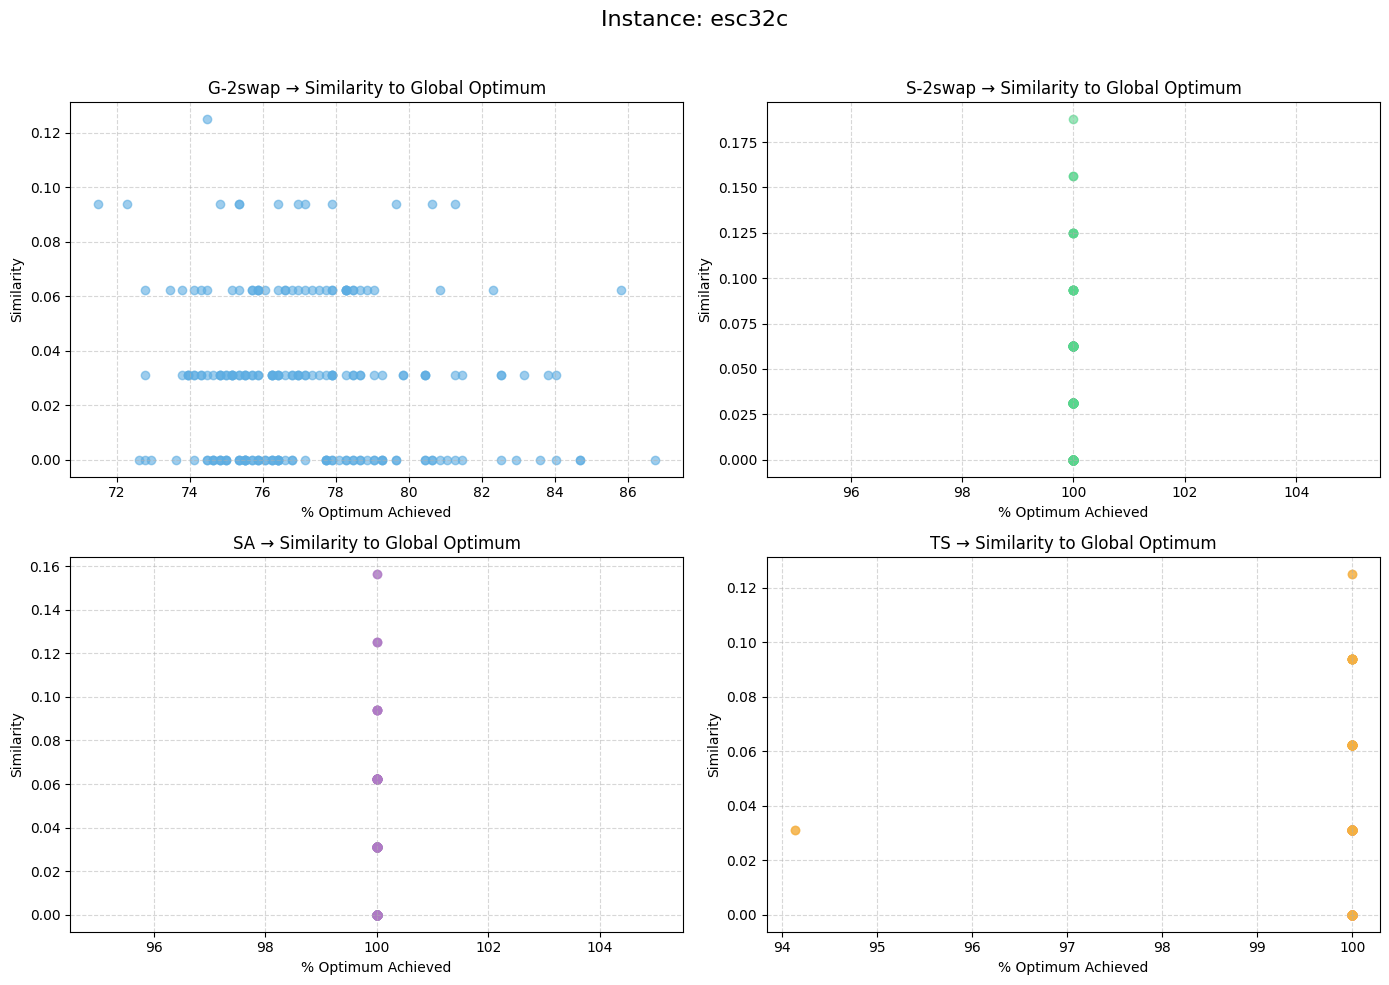

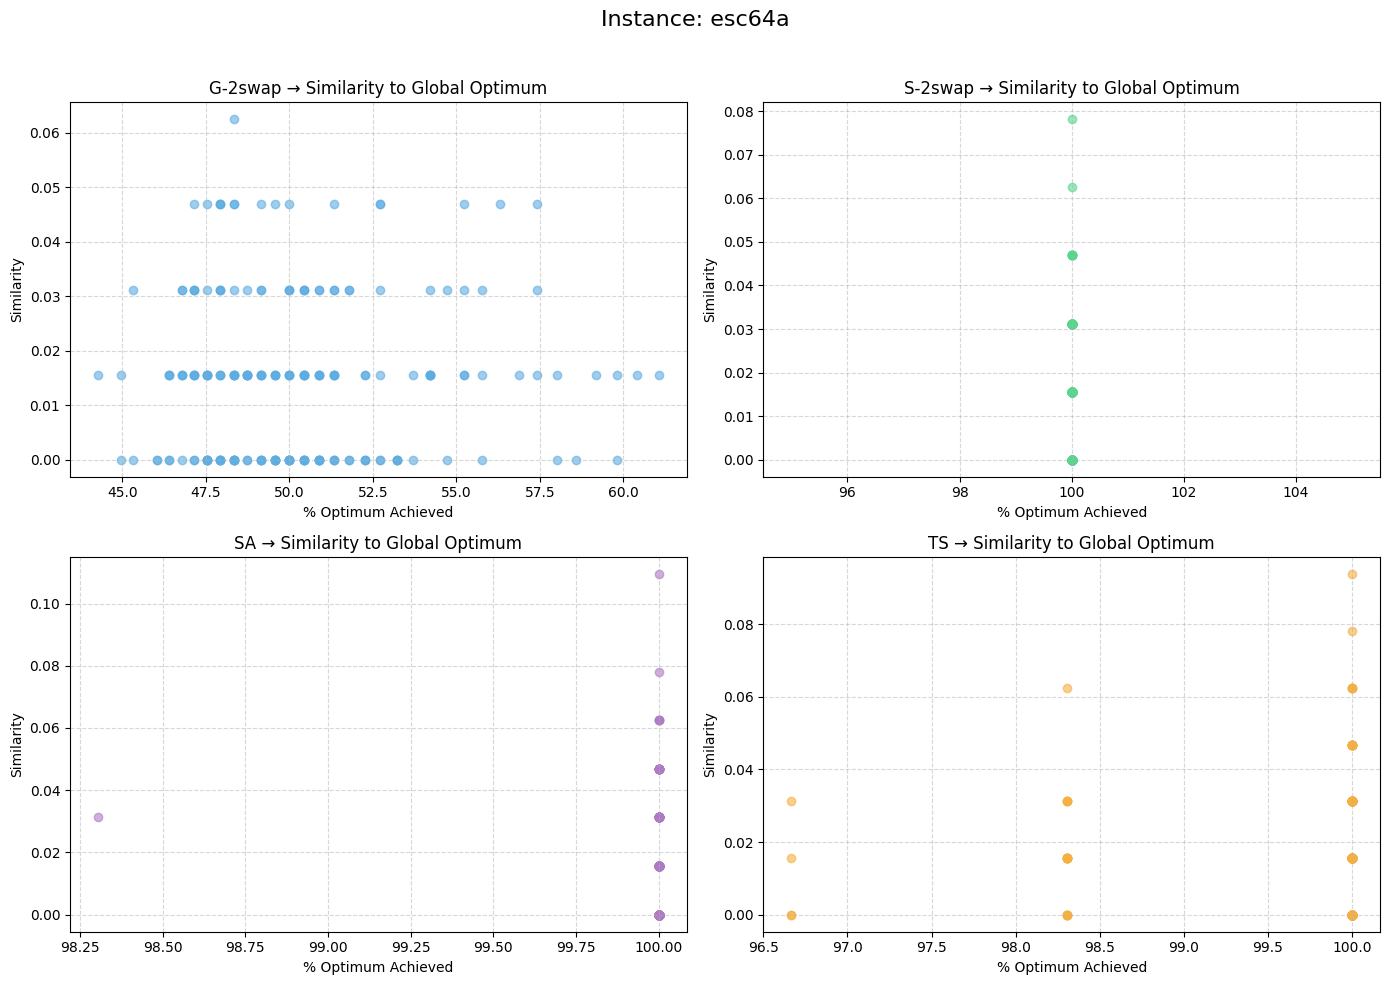

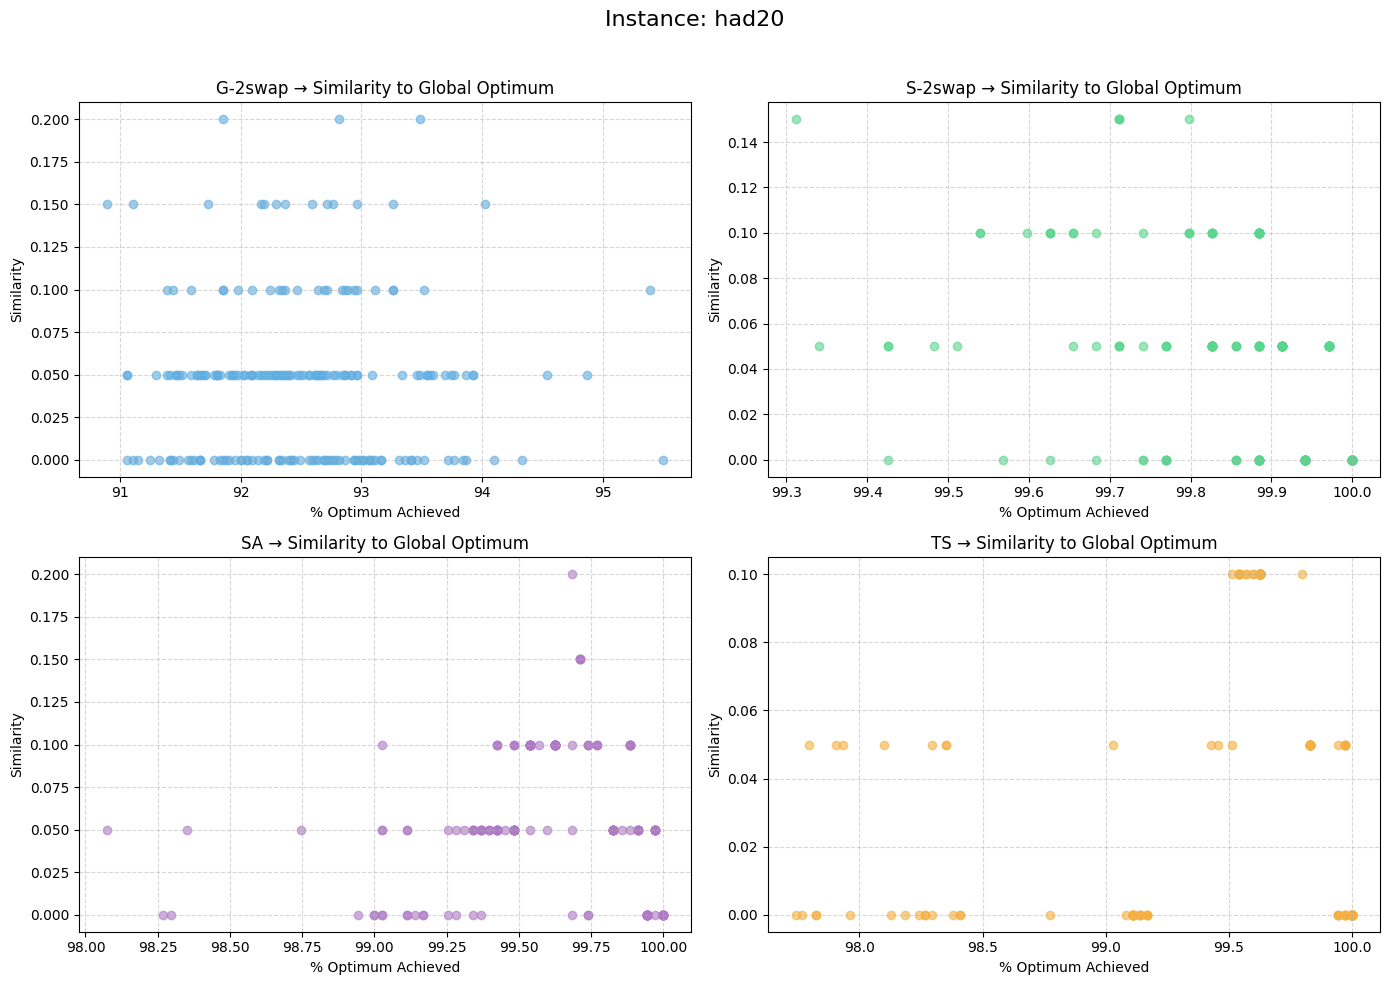

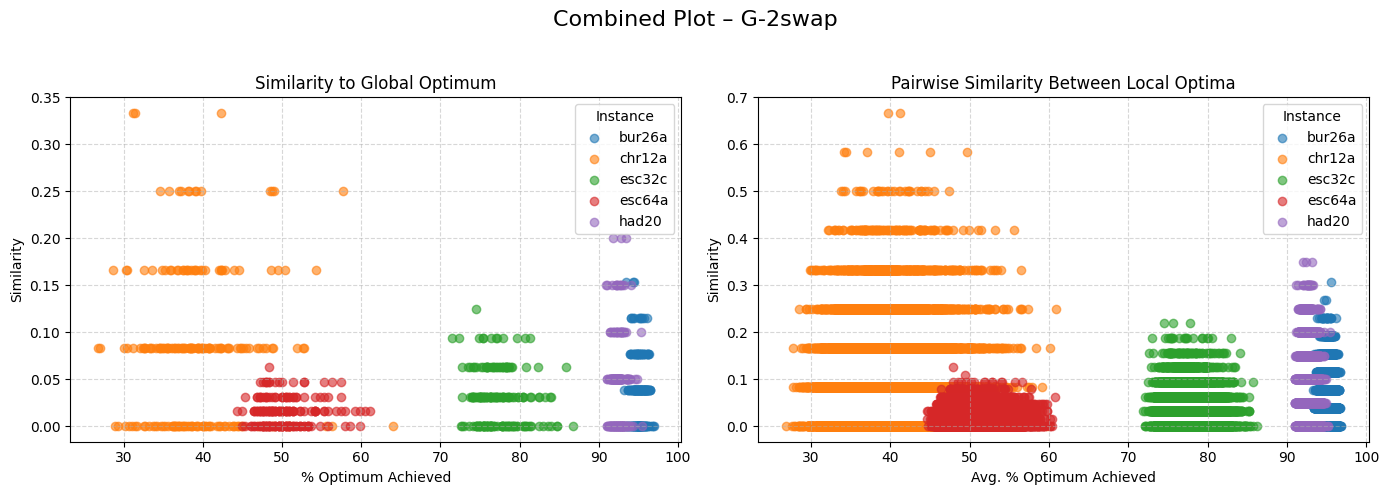

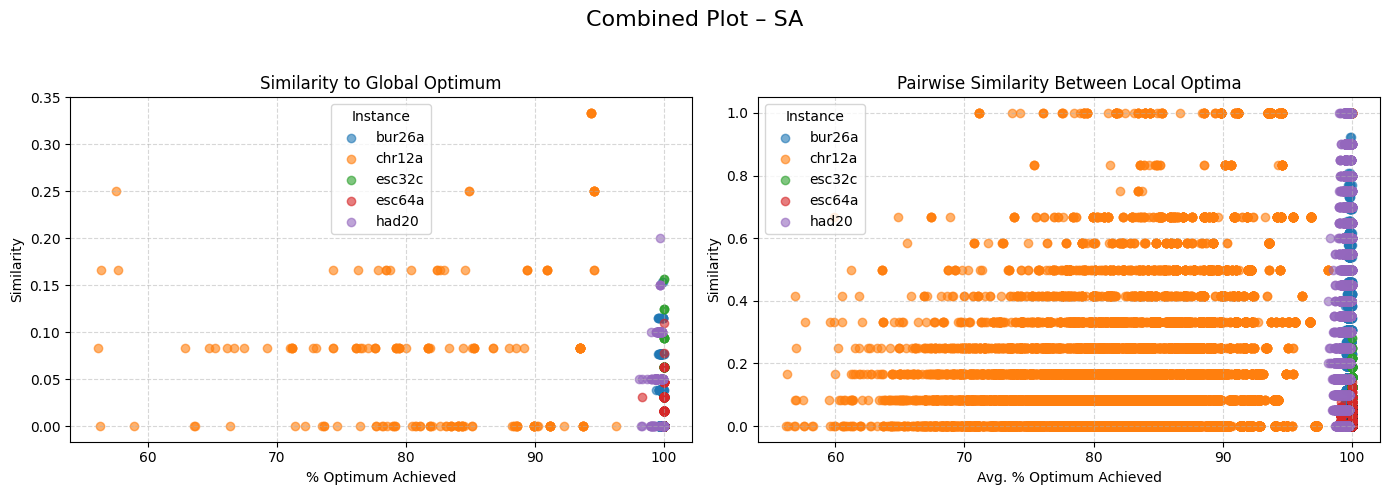

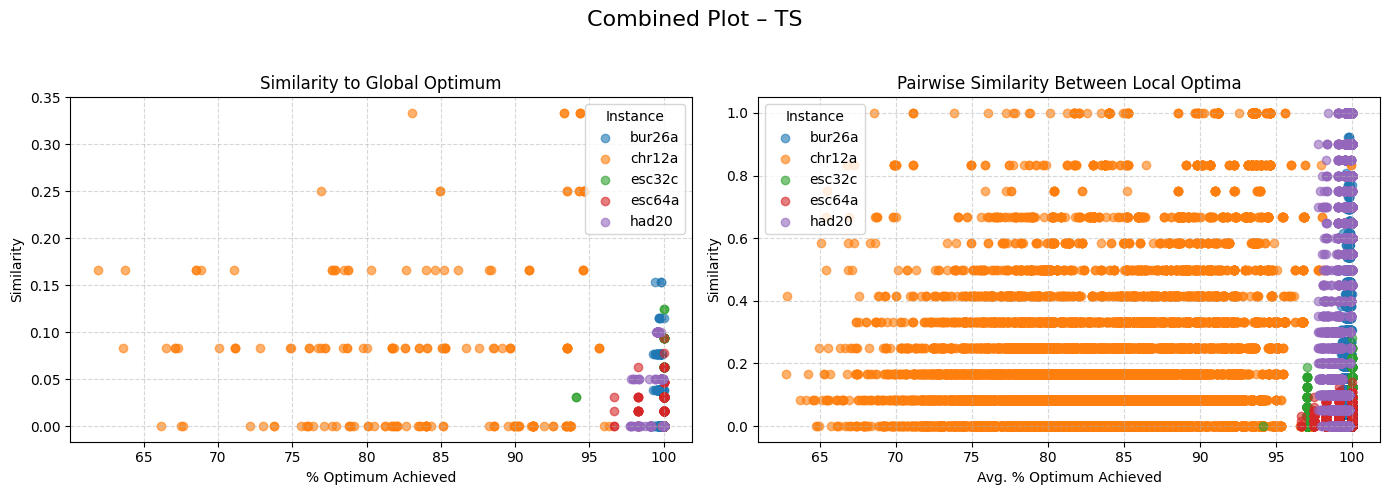

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Load data
merged_df = pd.read_csv("../experiment_results_ls.csv")
optimal_df = pd.read_csv("../optimal_data.csv")

# Normalize instance names
merged_df["Instance"] = merged_df["Instance"].str.replace(".dat", "", regex=False).str.lower()
optimal_df["name"] = optimal_df["name"].str.lower()

# Parse solution strings
def parse_solution(sol_str):
    sol_str = sol_str.strip("[]")
    return list(map(int, sol_str.split(','))) if sol_str else []

merged_df["ParsedSolution"] = merged_df["FinalSolution"].apply(parse_solution)
optimal_df["ParsedOptimal"] = optimal_df["permutation"].apply(parse_solution)

# Merge data
full_df = merged_df.merge(
    optimal_df[["name", "ParsedOptimal", "solution"]],
    left_on="Instance",
    right_on="name",
    how="left"
)

# Compute similarity to optimum
def compute_similarity(sol1, sol2):
    if not sol1 or not sol2 or len(sol1) != len(sol2):
        return np.nan
    return sum(a == b for a, b in zip(sol1, sol2)) / len(sol1)

full_df["%OptimumAchieved"] = (full_df["solution"] / full_df["FinalFitness"]) * 100

# Select subset of instances
instances = full_df["Instance"].unique()[:5]

# Algorithm and color mapping
algorithms = ["G-2swap", "S-2swap", "SA", "TS"]
algo_colors = {
    "G-2swap": "#5DADE2",
    "S-2swap": "#58D68D",
    "SA": "#AF7AC5",
    "TS": "#F5B041"
}

instance_colors = {name: color for name, color in zip(instances, plt.cm.tab10.colors)}

# Per-instance plots
for instance in instances:
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Instance: {instance}", fontsize=16)

    for i, algo in enumerate(algorithms):
        sub_df = full_df[(full_df["Instance"] == instance) & (full_df["Algorithm"] == algo)]
        if sub_df.empty:
            continue

        parsed_sols = sub_df["ParsedSolution"].tolist()
        percents = sub_df["%OptimumAchieved"].tolist()

        # Similarity to global optimum
        global_opt = sub_df["ParsedOptimal"].iloc[0]
        sim_to_global = [compute_similarity(sol, global_opt) for sol in parsed_sols]
        axs[i // 2, i % 2].scatter(percents, sim_to_global, color=algo_colors[algo], alpha=0.6)
        axs[i // 2, i % 2].set_title(f"{algo} → Similarity to Global Optimum")
        axs[i // 2, i % 2].set_xlabel("% Optimum Achieved")
        axs[i // 2, i % 2].set_ylabel("Similarity")
        axs[i // 2, i % 2].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"saved/{instance}_similarity_plots.svg", format="svg")
    plt.show()

# Combined plots per algorithm
for algo in algorithms:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Combined Plot – {algo}", fontsize=16)

    for instance in instances:
        sub_df = full_df[(full_df["Instance"] == instance) & (full_df["Algorithm"] == algo)]
        if sub_df.empty:
            continue

        parsed_sols = sub_df["ParsedSolution"].tolist()
        percents = sub_df["%OptimumAchieved"].tolist()
        global_opt = sub_df["ParsedOptimal"].iloc[0]
        instance_color = instance_colors[instance]

        # Similarity to global optimum
        sim_to_global = [compute_similarity(sol, global_opt) for sol in parsed_sols]
        axs[0].scatter(percents, sim_to_global, label=instance, color=instance_color, alpha=0.6)

        # Similarity to other local optima
        pairwise_sims = []
        avg_percents = []
        for (sol1, p1), (sol2, p2) in itertools.combinations(zip(parsed_sols, percents), 2):
            sim = compute_similarity(sol1, sol2)
            avg_percent = (p1 + p2) / 2
            pairwise_sims.append(sim)
            avg_percents.append(avg_percent)

        axs[1].scatter(avg_percents, pairwise_sims, label=instance, color=instance_color, alpha=0.6)

    axs[0].set_title("Similarity to Global Optimum")
    axs[0].set_xlabel("% Optimum Achieved")
    axs[0].set_ylabel("Similarity")
    axs[0].grid(True, linestyle="--", alpha=0.5)
    axs[0].legend(title="Instance")

    axs[1].set_title("Pairwise Similarity Between Local Optima")
    axs[1].set_xlabel("Avg. % Optimum Achieved")
    axs[1].set_ylabel("Similarity")
    axs[1].grid(True, linestyle="--", alpha=0.5)
    axs[1].legend(title="Instance")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"saved/{algo}_combined_similarity_plots.svg", format="svg")
    plt.show()


## 4. G, S – Multi-Random Start Analysis

- **Plot**:
- Horizontal axis: Number of restarts (up to at least 300)
- Vertical axis: Average and best quality of solutions found so far
- **Instances**: Use two (or a few) selected instances
- **Interpretation**:
- Analyze whether repeating the algorithm improves results
- Determine the optimal number of restarts based on diminishing returns

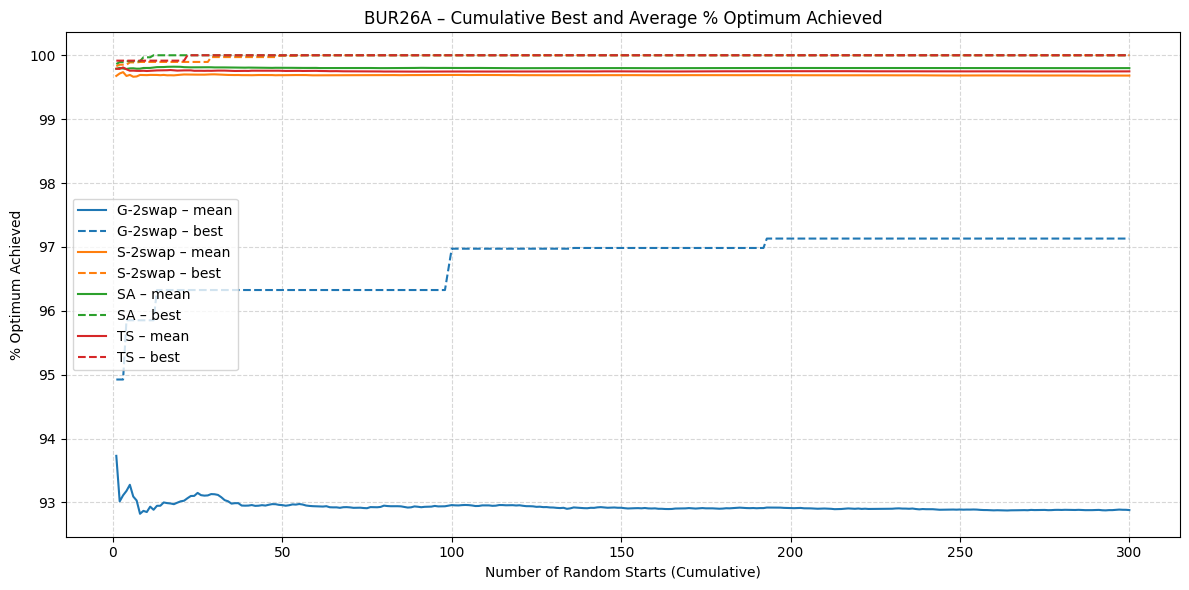

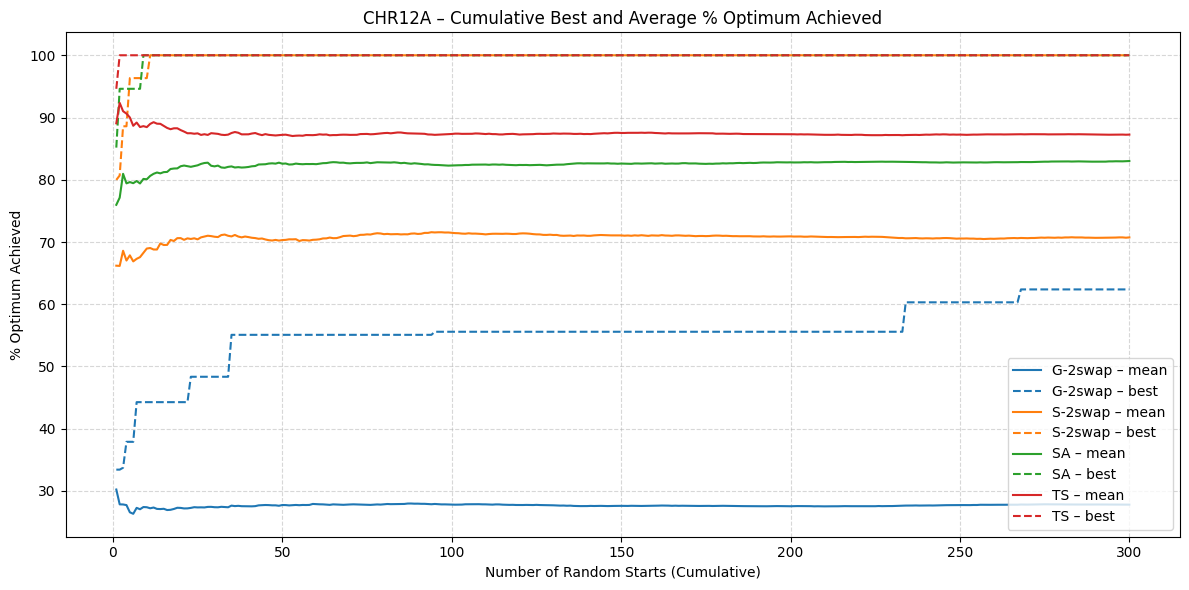

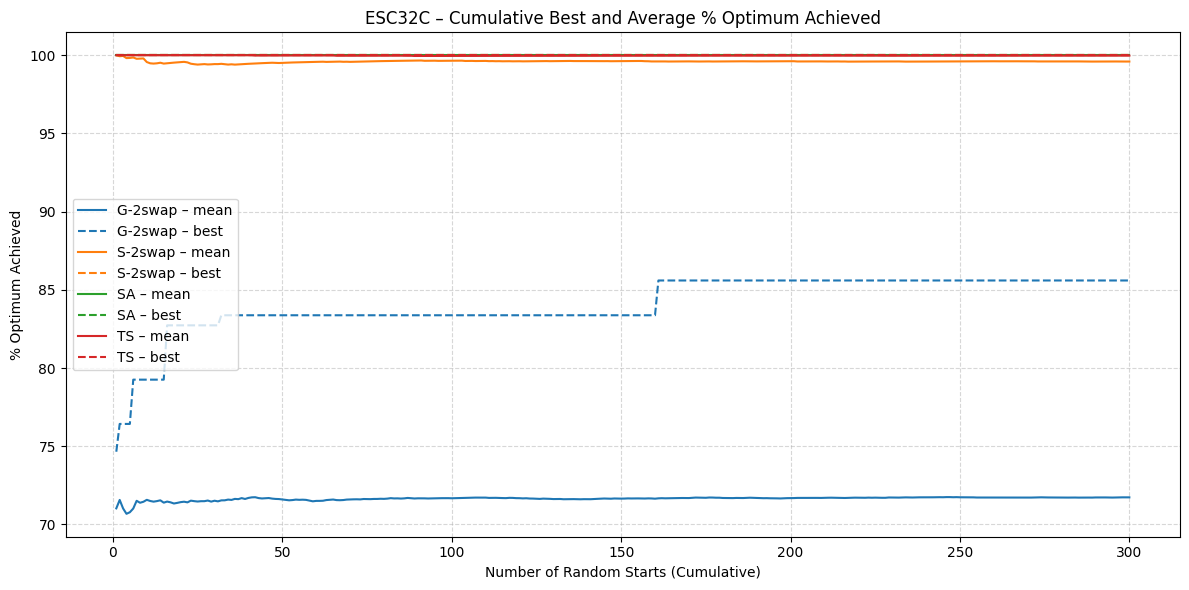

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the experiment data
df = pd.read_csv("../experiment_results_multistart.csv")
optimal_df = pd.read_csv("../optimal_data.csv")

# Normalize instance names
df["Instance"] = df["Instance"].str.replace(".dat", "", regex=False).str.lower()
optimal_df["name"] = optimal_df["name"].str.lower()

# Merge to get optimal fitness values
merged_df = df.merge(optimal_df[["name", "solution"]], left_on="Instance", right_on="name", how="left")

# Compute % Optimum Achieved
merged_df["%OptimumAchieved"] = (merged_df["solution"] / merged_df["FinalFitness"]) * 100

# Get algorithm list and color mapping
algorithms = sorted(merged_df["Algorithm"].unique())
algo_colors = {algo: color for algo, color in zip(algorithms, plt.cm.tab10.colors)}
instances = sorted(merged_df["Instance"].unique())

# Plot cumulative curves for each instance
for instance in instances:
    inst_df = merged_df[merged_df["Instance"] == instance]
    
    plt.figure(figsize=(12, 6))
    plt.title(f"{instance.upper()} – Cumulative Best and Average % Optimum Achieved")
    
    for algo in algorithms:
        algo_df = inst_df[inst_df["Algorithm"] == algo]
        if algo_df.empty:
            continue
        
        max_restart = algo_df["RandomStarts"].max()
        x_vals = []
        y_mean = []
        y_max = []

        for r in range(1, max_restart + 1):
            subset = algo_df[algo_df["RandomStarts"] <= r]
            if subset.empty:
                continue
            x_vals.append(r)
            y_mean.append(subset["%OptimumAchieved"].mean())
            y_max.append(subset["%OptimumAchieved"].max())

        color = algo_colors[algo]
        plt.plot(x_vals, y_mean, label=f"{algo} – mean", linestyle='-', linewidth=1.5, color=color)
        plt.plot(x_vals, y_max, label=f"{algo} – best", linestyle='--', linewidth=1.5, color=color)

    plt.xlabel("Number of Random Starts (Cumulative)")
    plt.ylabel("% Optimum Achieved")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"saved/{instance}_cumulative_curves.svg", format="svg")
    plt.show()


In [83]:
#TODO